# Cleaning Listing Data scraped in Q3

#### Reading the listing data 

In [1]:
#import all packages needed 
import pandas as pd
import numpy as np 
import re
from datetime import datetime 
import ast
from collections import Counter
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import geopandas as gpd
from scipy.stats import ttest_ind
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
!pip install urbanaccess pandana


#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Data/2. airbnb_data/Paris/Paris all detailed listings/Paris Q3 detailed listings.xlsx'
#read data, and quickly check if it is correctly read in
dataframe1= pd.read_excel(file_path)

In [2]:
dataframe1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67942 entries, 0 to 67941
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            67942 non-null  int64         
 1   listing_url                                   67942 non-null  object        
 2   scrape_id                                     67942 non-null  int64         
 3   last_scraped                                  67942 non-null  datetime64[ns]
 4   source                                        67942 non-null  object        
 5   name                                          67942 non-null  object        
 6   description                                   67416 non-null  object        
 7   neighborhood_overview                         38031 non-null  object        
 8   picture_url                                   67942 non-null  obje

#### Cleaning process 

In [3]:
#decided which columns will not be relevant for the first initial analysis
columns_to_drop =["name","description","host_location","host_thumbnail_url","host_name","bathrooms","first_review","last_review"
                  ,"listing_url","scrape_id","last_scraped", "host_picture_url","host_url", "host_has_profile_pic", 
                  "host_verifications","source","calendar_last_scraped","license","picture_url","host_about",
                             "neighbourhood","neighbourhood_group_cleansed","minimum_minimum_nights",
                             "maximum_minimum_nights","minimum_maximum_nights","maximum_maximum_nights",
                             "minimum_nights_avg_ntm","maximum_nights_avg_ntm","calendar_updated",
                             "neighborhood_overview","host_neighbourhood", "host_acceptance_rate", "host_since",
                  "minimum_nights","maximum_nights","has_availability"]
dataframe1 = dataframe1.drop(columns_to_drop, axis=1)

#solving trailing white space problem
string_columns = dataframe1.select_dtypes(include='object').columns.tolist()
for i in string_columns:
    dataframe1[i] = dataframe1[i].str.strip()

#missing values have always been checked during this cleaning with the function: print(dataframe1.isnull().mean()) 

#host_response_time, filling in the empty ones with "unknown"
dataframe1.host_response_time.fillna("unknown", inplace=True)
dataframe1.host_response_time.value_counts(normalize=True)

#adapting the host_response_rate column to better fit
# Removing the % sign from the host_response_rate string and converting to an integer
dataframe1.host_response_rate = dataframe1.host_response_rate.str[:-1].astype('float64')
# Bin into four categories
dataframe1.host_response_rate = pd.cut(dataframe1.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)
# Converting to string
dataframe1.host_response_rate = dataframe1.host_response_rate.astype('str')
# Replace nulls with 'unknown'
dataframe1.host_response_rate.replace('nan', 'unknown', inplace=True)

#these rows do not have that big of a missing value amount so we just delete the missing value rows here
col = ["host_identity_verified","host_listings_count","host_total_listings_count","host_is_superhost"]
for column in col:
    dataframe1.dropna(subset=[column], inplace=True)

# Category counts
dataframe1.host_response_rate.value_counts()
#fill out all NaN within string columns with ''
for column in string_columns:
    dataframe1[column] = dataframe1[column].fillna("")   

#fixing the "bathroom_text" column to only numbers and renaming it
def extract_numeric(value):
    numeric_part = re.search(r'\d+\.\d+|\d+', str(value))
    return float(numeric_part.group()) if numeric_part else None
dataframe1['bathrooms_text'] = dataframe1['bathrooms_text'].apply(extract_numeric)
dataframe1.rename(columns={'bathrooms_text': 'bathrooms'}, inplace=True)

#dropping those that still have no bathroom amount 
dataframe1.dropna(subset=["bathrooms"], inplace=True)
    
#delete those that have no information about both beds and bedrooms
dataframe1.dropna(subset=['beds', 'bedrooms'], how='all', inplace=True)

#dropping those with +4 bedrooms (outliers) and no information about bedroom and between 1-4 beds is a studio so 0 bedrooms
dataframe1.loc[(dataframe1['bedrooms'].isnull()) & (dataframe1['beds'].between(1, 4)), 'bedrooms'] = 0
dataframe1.drop(dataframe1[(dataframe1['bedrooms'].isnull()) & (dataframe1['beds'] > 4)].index, inplace=True)

#fill in all the other empty values with the amount of bedrooms 
dataframe1['beds'].fillna(dataframe1['bedrooms'], inplace=True)

#dropping those that still have no bedroom amount 
dataframe1.dropna(subset=["bedrooms"], inplace=True)

#Simplifying the property_types in to 4 categories
dataframe1.property_type.replace({
    'Barn': 'House',
    'Boat': 'Other',
    'Bus': 'Other',
    'Camper/RV': 'Other',
    'Casa particular': 'House',
    'Cave': 'Other',
    'Dome': 'Other',
    'Earthen home': 'House',
    'Entire bed and breakfast': 'Hotel',    
    'Entire bungalow': 'House',
    'Entire condo': 'Apartmen',
    'Entire guesthouse': 'House',
    'Entire home': 'House',
    'Entire guest suite': 'Apartment',
    'Entire rental unit': 'Apartment',
    'Entire loft': 'Apartment',
    'Entire home/apt': 'House',
    'Entire place': 'House',
    'Entire serviced apartment': 'Apartment',
    'Entire townhouse': 'House',
    'Entire villa': 'House',
    'Entire vacation home': 'House',
    'Floor': 'Other',
    'Houseboat': 'Other',
    'Private room': 'Apartment',
    'Island': 'Other',
    'Private room in bed and breakfast': 'Hotel',    
    'Private room in boat': 'Other',
    'Private room in casa particular': 'House',
    'Private room in condo': 'Apartment',
    'Private room in guest suite': 'Apartment',
    'Private room in earthen home': 'House',
    'Private room in home': 'House',
    'Private room in guesthouse': 'House',
    'Private room in loft': 'Apartment',
    'Private room in hostel': 'Hotel',
    'Private room in rental unit': 'Apartment',
    'Private room in townhouse': 'House',
    'Private room in tiny home': 'House',
    'Private room in serviced apartment': 'Apartment',
    'Room in bed and breakfast': 'Hotel',
    'Private room in villa': 'House',
    'Room in serviced apartment': 'Apartment',
    'Room in boutique hotel': 'Hotel',
    'Room in hotel': 'Hotel',
    'Room in hostel': 'Hotel',
    'Shared room in bed and breakfast': 'Hotel',
    'Shared room in boutique hotel': 'Hotel',
    'Shared room in cabin': 'Other',
    'Shared room in boat': 'Other',
    'Shared room in condo': 'Apartment',
    'Shared room in farm stay': 'Other',
    'Shared room in guesthouse': 'House',
    'Shared room in casa particular': 'House',
    'Shared room in ice dome': 'Other',
    'Shared room in home': 'House',
    'Shared room in hostel': 'Hotel',
    'Shared room in hotel': 'Hotel',
    'Shared room in rental unit': 'Apartment',
    'Tiny home': 'House',
    'Shared room in loft': 'Apartment',
    'Shared room in townhouse': 'House',
    'Shared room in tiny home': 'House',
    }, inplace=True)

# Replacing other categories with 'other'
dataframe1.loc[~dataframe1.property_type.isin(['House', 'Apartment','Hotel']), 'property_type'] = 'Other'
#dataframe1['property_type'].value_counts()

#changing the name from neighbourhoud_cleansed to neighbourhood
dataframe1.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)

#convert the necessary columns to a boolean type, which is easier to use
columns_to_convert = ['host_is_superhost', 'instant_bookable', 'host_identity_verified'] 
for column in columns_to_convert:
    dataframe1[column] = dataframe1[column].replace({'f': False, 't': True}).astype(bool)

In [4]:
dataframe1.info()
print(dataframe1.isnull().mean())

<class 'pandas.core.frame.DataFrame'>
Index: 66277 entries, 0 to 67941
Data columns (total 39 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            66277 non-null  int64  
 1   host_id                                       66277 non-null  int64  
 2   host_response_time                            66277 non-null  object 
 3   host_response_rate                            66277 non-null  object 
 4   host_is_superhost                             66277 non-null  bool   
 5   host_listings_count                           66277 non-null  float64
 6   host_total_listings_count                     66277 non-null  float64
 7   host_identity_verified                        66277 non-null  bool   
 8   neighbourhood                                 66277 non-null  object 
 9   latitude                                      66277 non-null  floa

#### Seperating amenities column into seperate boolean columns + total_amenities column

In [5]:
# Convert the string representation of lists to actual lists
dataframe1["amenities"] = dataframe1["amenities"].apply(ast.literal_eval)

In [6]:
#making a unique list out of all the different kind of amenities that there are
unique_items_set = set.union(*dataframe1["amenities"].apply(set))
print(unique_items_set)
print(len(unique_items_set)) 
#the one that is shown here is taken after the adjustments you can see below

{'Fast wifi – 273 Mbps', 'Barre de son LG  Bluetooth sound system', 'Sauter stainless steel double oven', 'Nad sound system with Bluetooth and aux', '50" TV with Amazon Prime Video, Netflix', 'Karlstein oven', '26" HDTV', 'Apple pods Bluetooth sound system', 'Phantom Bluetooth sound system', '. sound system', '32" HDTV with Netflix, standard cable', '150" HDTV', 'Aleppo soap body soap', 'Shared outdoor pool - available all year, open specific hours, lap pool', '40" HDTV with Amazon Prime Video, Chromecast', 'No shampoo', 'Coffee maker: drip coffee maker, pour-over coffee', '48" HDTV with Apple TV, HBO Max, Netflix, premium cable', 'Body soap', 'Natural brand conditioner', 'Fast wifi – 403 Mbps', 'Coffee maker: drip coffee maker, Nespresso, pour-over coffee', 'TV with Netflix, standard cable, DVD player', '43" HDTV with Amazon Prime Video, Apple TV, Netflix, standard cable', 'HDTV with Amazon Prime Video, Apple TV, Netflix', '65" HDTV with Disney+, Netflix', 'TV with Netflix, Amazon Pri

In [7]:
#with the code down below we will simplify the amenities to reduce the amount of amenities in dataframe1

oven_items_set = {item for item in unique_items_set if 'oven' in item.lower()}
def replace_oven_items(item_list):
    return ['oven' if item in oven_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_oven_items)

soap_items_set = {item for item in unique_items_set if 'soap' in item.lower()}
def replace_soap_items(item_list):
    return ['soap' if item in soap_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_soap_items)

shampoo_items_set = {item for item in unique_items_set if 'shampoo' in item.lower()}
def replace_shampoo_items(item_list):
    return ['shampoo' if item in shampoo_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_shampoo_items)

wifi_items_set = {item for item in unique_items_set if 'wifi' in item.lower()}
def replace_wifi_items(item_list):
    return ['wifi' if item in wifi_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_wifi_items)

special_items_set = {item for item in unique_items_set if any(keyword in item for keyword in ['Netflix', 'Disney+', 'Amazon Prime'])}
def replace_and_add_broadcast(item_list):
    # Replace items from special_items_set with 'Broadcast'
    item_list = ['broadcast' if item in special_items_set else item for item in item_list]
    # Add 'TV' to the list if modified
    modified = any(item == 'broadcast' for item in item_list)
    if modified:
        item_list.append('TV')
    return item_list
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_and_add_broadcast)

tv_items_set = {item for item in unique_items_set if 'tv' in item.lower()}
def replace_tv_items(item_list):
    return ['tv' if item in tv_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_tv_items)

ref_items_set = {item for item in unique_items_set if 'refrigerator' in item.lower()}
def replace_ref_items(item_list):
    return ['refrigerator' if item in ref_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_ref_items)

coffee_items_set = {item for item in unique_items_set if 'coffee' in item.lower()}
def replace_coffee_items(item_list):
    return ['coffee' if item in coffee_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_coffee_items)

sound_items_set = {item for item in unique_items_set if any(keyword in item for keyword in ['sound system', 'Bluetooth'])}
def replace_sound_items(item_list):
    item_list = ['sound system' if item in sound_items_set else item for item in item_list]
    return item_list
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_sound_items)

stove_items_set = {item for item in unique_items_set if 'stove' in item.lower()}
def replace_stove_items(item_list):
    return ['stove' if item in stove_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_stove_items)

cond_items_set = {item for item in unique_items_set if 'conditioner' in item.lower()}
def replace_cond_items(item_list):
    return ['conditioner' if item in cond_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_cond_items)

park_items_set = {item for item in unique_items_set if 'parking' in item.lower()}
def replace_park_items(item_list):
    return ['parking' if item in park_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_park_items)

clothing_items_set = {item for item in unique_items_set if 'clothing storage' in item.lower()}
def replace_clothing_items(item_list):
    return ['clothing storage' if item in clothing_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_clothing_items)

exercise_items_set = {item for item in unique_items_set if 'exercise equipment' in item.lower()}
def replace_exercise_items(item_list):
    return ['exercise equipment' if item in exercise_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_exercise_items)

children_items_set = {item for item in unique_items_set if 'children' in item.lower()}
def replace_children_items(item_list):
    return ['toys children' if item in children_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_children_items)

bbq_items_set = {item for item in unique_items_set if 'bbq' in item.lower()}
def replace_bbq_items(item_list):
    return ['bbq' if item in bbq_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_bbq_items)

pool_items_set = {item for item in unique_items_set if 'pool' in item.lower()}
def replace_pool_items(item_list):
    return ['pool' if item in pool_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_pool_items)

hot_items_set = {item for item in unique_items_set if 'hot tub' in item.lower()}
def replace_hot_items(item_list):
    return ['hot tub' if item in hot_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_hot_items)

backyard_items_set = {item for item in unique_items_set if 'backyard' in item.lower()}
def replace_backyard_items(item_list):
    return ['backyard' if item in backyard_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_backyard_items)

gym_items_set = {item for item in unique_items_set if 'gym' in item.lower()}
def replace_gym_items(item_list):
    return ['gym' if item in gym_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_gym_items)

view_items_set = {item for item in unique_items_set if 'view' in item.lower()}
def replace_view_items(item_list):
    return ['view' if item in view_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_view_items)

crib_items_set = {item for item in unique_items_set if 'crib' in item.lower()}
def replace_crib_items(item_list):
    return ['crib' if item in crib_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_crib_items)

gc_items_set = {item for item in unique_items_set if 'game console' in item.lower()}
def replace_gc_items(item_list):
    return ['game console' if item in gc_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_gc_items)

sauna_items_set = {item for item in unique_items_set if 'sauna' in item.lower()}
def replace_sauna_items(item_list):
    return ['sauna' if item in sauna_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_sauna_items)

In [8]:
#last step to clean the amenities is removing the ones that do not appear 6000 times or more in the column
flat_list = [word for sublist in dataframe1["amenities"] for word in sublist]
word_counts = Counter(flat_list)
filtered_word_set = {word for word, count in word_counts.items() if count < 6000}
common_elements = list(filtered_word_set & unique_items_set)

def remove_common_elements(item_list):
    return [item for item in item_list if item not in common_elements]
dataframe1['amenities'] = dataframe1['amenities'].apply(remove_common_elements)

unique_items_set = set.union(*dataframe1["amenities"].apply(set))
#only 71 unique items left, which is an acceptable amount and now we can make columns out of these ones

In [9]:
len(unique_items_set)

71

In [10]:
#making new columns for the amenities indivually with a 0 or 1 inside of them 
for item in unique_items_set:
    dataframe1[item] = dataframe1["amenities"].apply(lambda x: int(item in x))

In [11]:
#now we will be able to remove the 'amenities' column
dataframe1 = dataframe1.drop('amenities', axis=1)

In [12]:
dataframe1.columns[38]

'Smoke alarm'

In [13]:
# Calculate the total number of amenities for each listing and make this a new column
dataframe1['total_amenities'] = dataframe1.iloc[:, 38:-1].sum(axis=1)

#### Handling review columns 

In [14]:
#to many missing values in these columns, thus removing them
review_columns = ["review_scores_rating",'review_scores_accuracy',"review_scores_cleanliness",
                  "review_scores_checkin","review_scores_communication","review_scores_location",
                  "review_scores_value","reviews_per_month"]                                    

# Impute missing values with 0
dataframe1[review_columns] = dataframe1[review_columns].fillna(0)

# Create the 'Listing_reviewed' column
dataframe1['listing_reviewed'] = dataframe1[review_columns].sum(axis=1).apply(lambda x: 0 if x == 0 else 1)

#### Applying encoding techniques 

In [15]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Splitting the columns up in one-hot and label encoding
categorical_columns_one_hot = ['neighbourhood', 'property_type', 'room_type']  # For one-hot encoding
categorical_columns_label = ['host_response_time', 'host_response_rate']  # For label encoding

# One-Hot Encoding
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(dataframe1[categorical_columns_one_hot])

# Manually create feature names for the one-hot encoded columns
one_hot_feature_names = []
for i, column in enumerate(categorical_columns_one_hot):
    categories = one_hot_encoder.categories_[i]
    one_hot_feature_names.extend([f"{column}_{category}" for category in categories])

one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_feature_names, index=dataframe1.index)

# Label Encoding
label_encoder = LabelEncoder()
for col in categorical_columns_label:
    dataframe1[col] = label_encoder.fit_transform(dataframe1[col])

# Concatenate the one-hot encoded columns back to the original dataframe
dataframe1 = pd.concat([dataframe1, one_hot_encoded_df], axis=1)

# Drop the original string columns
dataframe1.drop(categorical_columns_one_hot, axis=1, inplace=True)

C:\Users\anton\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Making columns booleans if needed 

In [16]:
# Convert columns with exclusively 0s and 1s to boolean
for col in dataframe1.columns:
    unique_values = dataframe1[col].unique()
    if set(unique_values).issubset({0, 1}):
        dataframe1[col] = dataframe1[col].astype(bool)

#### Saving the model

In [17]:
#downloading the cleaned_dataset
dataframe1.to_csv('cleaned_dataset_paris.csv', index=False)

# Cleaning Calendar Data scraped in Q1 and Q3

#### Reading the calendar data

In [18]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np
%matplotlib inline

#reading in the data scraped Q1
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Data/2. airbnb_data/Paris/Q1 airbnb_data Paris/calendar/calendar.csv'
data1 = pd.read_csv(file_path)

#reading in the data scraped Q3
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Data/2. airbnb_data/Paris/Q3 airbnb_data Paris/calendar/calendar.csv'
data3 = pd.read_csv(file_path)

In [19]:
data1.info()
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20703571 entries, 0 to 20703570
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.1+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24798862 entries, 0 to 24798861
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.3+ GB


#### Cleaning process 

In [20]:
#SCRAPED Q1
#fixing the price column with removing the dollar sign and making it numerical
data1['price'] = data1['price'].replace('[\$,]', '', regex=True).astype(float)
#dropping adjusted_price, maximum_nights, minimum_nights since it brings no additional value
data1 = data1.drop('adjusted_price', axis=1)
data1 = data1.drop('maximum_nights', axis=1)
data1 = data1.drop('minimum_nights', axis=1)
#making sure it is datetime
data1['date']=pd.to_datetime(data1['date'])
#including the day of the week in the dataset
data1['weekday'] = pd.Series(data1.date).dt.dayofweek
# Convert 'date' to datetime
data1['date'] = pd.to_datetime(data1['date'])
#renaming listing_id to id
data1.rename(columns={'listing_id': 'id'}, inplace=True)
#including the season
import pandas as pd
import numpy as np
# Extract season from date
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'
data1['season'] = data1['date'].dt.month.map(get_season)
# Convert 'available' column to boolean
data1['available'] = data1['available'].map({'f': False, 't': True})
data1.head()

#SCRAPED Q3
#fixing the price column with removing the dollar sign and making it numerical
data3['price'] = data3['price'].replace('[\$,]', '', regex=True).astype(float)
#dropping adjusted_price, maximum_nights, minimum_nights since it brings no additional value
data3 = data3.drop('adjusted_price', axis=1)
data3 = data3.drop('maximum_nights', axis=1)
data3 = data3.drop('minimum_nights', axis=1)
#making sure it is datetime
data3['date']=pd.to_datetime(data3['date'])
#including the day of the week in the dataset
data3['weekday'] = pd.Series(data3.date).dt.dayofweek
# Convert 'date' to datetime
data3['date'] = pd.to_datetime(data3['date'])
#renaming listing_id to id
data3.rename(columns={'listing_id': 'id'}, inplace=True)
#including the season
import pandas as pd
import numpy as np
# Extract season from date
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'
data3['season'] = data3['date'].dt.month.map(get_season)
# Convert 'available' column to boolean
data3['available'] = data3['available'].map({'f': False, 't': True})
data3.head()

id       date  available  price  weekday  season
0  3109 2023-09-05      False  110.0        1  Autumn
1  3109 2023-09-06      False  110.0        2  Autumn
2  3109 2023-09-07      False  110.0        3  Autumn
3  3109 2023-09-08       True  110.0        4  Autumn
4  3109 2023-09-09       True  110.0        5  Autumn

In [21]:
import pandas as pd

#print start and end date scraped Q1
start_date1 = data1['date'].min()
end_date1 = data1['date'].max()

print("Start Date:", start_date1)
print("End Date:", end_date1)

#print start and end date scraped Q3
start_date3 = data3['date'].min()
end_date3 = data3['date'].max()

print("Start Date:", start_date3)
print("End Date:", end_date3)

Start Date: 2023-03-13 00:00:00
End Date: 2024-03-27 00:00:00
Start Date: 2023-09-04 00:00:00
End Date: 2024-09-15 00:00:00


In [22]:
#checking missing values
print(data1.isnull().mean())
print(data3.isnull().mean())

id           0.000000
date         0.000000
available    0.000000
price        0.000036
weekday      0.000000
season       0.000000
dtype: float64
id           0.000000e+00
date         0.000000e+00
available    0.000000e+00
price        2.419466e-07
weekday      0.000000e+00
season       0.000000e+00
dtype: float64


In [23]:
#removing the missing values from the dataset scraped in Q1 after seeing that there are not that many missing values
data1.dropna(inplace=True)
print(data1.isnull().mean())

#removing the missing values from the datasets scraped in Q3 after seeing that there are not that many missing values
data3.dropna(inplace=True)
print(data3.isnull().mean())

id           0.0
date         0.0
available    0.0
price        0.0
weekday      0.0
season       0.0
dtype: float64
id           0.0
date         0.0
available    0.0
price        0.0
weekday      0.0
season       0.0
dtype: float64


In [24]:
# Group by both month and year
mean_price = data1.groupby([data1['date'].dt.year, data1['date'].dt.month])['price'].mean()

# Print the average prices
print(mean_price)

date  date
2023  3       179.595850
      4       189.688795
      5       190.314363
      6       198.152465
      7       191.321369
      8       186.818521
      9       203.902950
      10      206.956559
      11      188.736951
      12      199.139368
2024  1       208.545141
      2       210.874821
      3       211.239672
Name: price, dtype: float64


#### Applying encoding techniques 

In [25]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Splitting the columns up in one-hot and label encoding
categorical_columns_one_hot = ['season']  # For one-hot encoding

# One-Hot Encoding
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(data1[categorical_columns_one_hot])

# Manually create feature names for the one-hot encoded columns
one_hot_feature_names = []
for i, column in enumerate(categorical_columns_one_hot):
    categories = one_hot_encoder.categories_[i]
    one_hot_feature_names.extend([f"{column}_{category}" for category in categories])

one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_feature_names, index=data1.index)

# Concatenate the one-hot encoded columns back to the original dataframe
data1 = pd.concat([data1, one_hot_encoded_df], axis=1)

# Drop the original string columns
data1.drop(categorical_columns_one_hot, axis=1, inplace=True)

C:\Users\anton\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [26]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Splitting the columns up in one-hot and label encoding
categorical_columns_one_hot = ['season']  # For one-hot encoding

# One-Hot Encoding
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(data3[categorical_columns_one_hot])

# Manually create feature names for the one-hot encoded columns
one_hot_feature_names = []
for i, column in enumerate(categorical_columns_one_hot):
    categories = one_hot_encoder.categories_[i]
    one_hot_feature_names.extend([f"{column}_{category}" for category in categories])

one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_feature_names, index=data3.index)

# Concatenate the one-hot encoded columns back to the original dataframe
data3 = pd.concat([data3, one_hot_encoded_df], axis=1)

# Drop the original string columns
data3.drop(categorical_columns_one_hot, axis=1, inplace=True)

C:\Users\anton\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Making columns booleans if needed 

In [27]:
# Convert columns with exclusively 0s and 1s to boolean
for col in data1.columns:
    unique_values = data1[col].unique()
    if set(unique_values).issubset({0, 1}):
        data1[col] = data1[col].astype(bool)

In [28]:
# Convert columns with exclusively 0s and 1s to boolean
for col in data3.columns:
    unique_values = data3[col].unique()
    if set(unique_values).issubset({0, 1}):
        data3[col] = data3[col].astype(bool)

####  Date variables engineered

In [29]:
# Making seperate columns for different date characteristics
data1['year'] = pd.to_datetime(data1['date']).dt.year
data1['month'] = pd.to_datetime(data1['date']).dt.month
data1['day'] = pd.to_datetime(data1['date']).dt.day
data1['day_of_year'] = pd.to_datetime(data1['date']).dt.dayofyear

# Making seperate columns for different date characteristics
data3['year'] = pd.to_datetime(data3['date']).dt.year
data3['month'] = pd.to_datetime(data3['date']).dt.month
data3['day'] = pd.to_datetime(data3['date']).dt.day
data3['day_of_year'] = pd.to_datetime(data3['date']).dt.dayofyear

In [30]:
data1["price"].describe()

count    2.070283e+07
mean     1.972066e+02
std      6.508274e+02
min      0.000000e+00
25%      7.500000e+01
50%      1.150000e+02
75%      2.000000e+02
max      1.001400e+05
Name: price, dtype: float64

In [31]:
data3["price"].describe()

count    2.479886e+07
mean     2.504807e+02
std      6.738456e+02
min      8.000000e+00
25%      8.100000e+01
50%      1.300000e+02
75%      2.300000e+02
max      9.310500e+04
Name: price, dtype: float64

#### Save the cleaned datasets 

In [33]:
data1.to_csv('cleaned_calendar_Q1.csv', index=False)
data3.to_csv('cleaned_calendar_Q3.csv', index=False)

# Merging data

In [34]:
import pandas as pd
import numpy as np 
import re
from datetime import datetime 
import ast
from collections import Counter
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import geopandas as gpd
from scipy.stats import ttest_ind
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
!pip install urbanaccess pandana

#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Paris Airbnb_Spatiotemporal_Analysis/Data Cleaning Listings/cleaned_calendar_Q1.csv'
#read data, and quickly check if it is correctly read in
data1= pd.read_csv(file_path)

#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Paris Airbnb_Spatiotemporal_Analysis/Data Cleaning Listings/cleaned_calendar_Q3.csv'
#read data, and quickly check if it is correctly read in
data3= pd.read_csv(file_path)

#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Paris Airbnb_Spatiotemporal_Analysis/Data Cleaning Listings/cleaned_dataset_paris.csv'
#read data, and quickly check if it is correctly read in
df_listing_cleaned_paris= pd.read_csv(file_path)

#### Merging Calendar Data of Q1 and Q3 

In [35]:
# Find the overlapping date
overlap_date = min(data1['date'].max(), data3['date'].min())

# Slice dataset 1 up to the overlapping date
data1_until_overlap = data1[data1['date'] <= overlap_date]

# Slice dataset 2 from the overlapping date onwards
data3_from_overlap = data3[data3['date'] >= overlap_date]

# Concatenate the two sliced datasets
df_merged_calendar_paris = pd.concat([data1_until_overlap, data3_from_overlap], ignore_index=True)

In [36]:
df_merged_calendar_paris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34712269 entries, 0 to 34712268
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   id             int64  
 1   date           object 
 2   available      bool   
 3   price          float64
 4   weekday        int64  
 5   season_Autumn  bool   
 6   season_Spring  bool   
 7   season_Summer  bool   
 8   season_Winter  bool   
 9   year           int64  
 10  month          int64  
 11  day            int64  
 12  day_of_year    int64  
dtypes: bool(5), float64(1), int64(6), object(1)
memory usage: 2.2+ GB


#### Merging Calendar data with Listing data 

In [37]:
#firstly we are dropping half of the listings in the listing dataset, since this dataset is to large to handle
# Randomly drop half of the rows
df_listing_cleaned_halved_paris = df_listing_cleaned_paris.sample(frac=0.5, random_state=42)  # Use random_state for reproducibility

# Print original and resulting shapes
print(f"Original DataFrame shape: {df_listing_cleaned_paris.shape}")
print(f"DataFrame after dropping half of the rows shape: {df_listing_cleaned_halved_paris.shape}")

Original DataFrame shape: (66277, 136)
DataFrame after dropping half of the rows shape: (33138, 136)


In [49]:
import pandas as pd

# Assuming df_merged_calendar_paris and df_listing_cleaned_halved_paris are your DataFrames
# Assuming 'id' is the common key in both datasets

# Perform an inner merge to keep only the IDs present in both datasets
final_merged_data = pd.merge(df_merged_calendar_paris, df_listing_cleaned_halved_paris, on='id', how='inner', suffixes=('_merged', '_additional'))

# Count number of rows and unique IDs after merging
total_rows_after = final_merged_data.shape[0]
unique_ids_after = final_merged_data['id'].nunique()

print(f"Total number of rows after merging: {total_rows_after}")
print(f"Total number of unique IDs after merging: {unique_ids_after}")

# Now final_merged_data contains merged information with IDs present in both datasets

Total number of rows after merging: 10370440
Total number of unique IDs after merging: 19671


In [50]:
final_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10370440 entries, 0 to 10370439
Columns: 159 entries, id to nearby_transport
dtypes: bool(110), datetime64[ns](1), float64(21), int64(27)
memory usage: 4.8 GB


In [51]:
#check if no columns are duplicated
merged_columns = final_merged_data.columns

print("Columns with suffixes:")
for col in merged_columns:
    if col.endswith('_merged') or col.endswith('_additional'):
        print(col)

Columns with suffixes:
price_merged
price_additional


In [52]:
# Check unique values in 'price_additional' column
unique_prices = final_merged_data['price_merged'].nunique()
print("Unique values in 'price_merged' column:", unique_prices)

# Check unique values in 'price_additional' column
unique_prices = final_merged_data['price_additional'].nunique()
print("Unique values in 'price_additional' column:", unique_prices)

Unique values in 'price_merged' column: 3675
Unique values in 'price_additional' column: 887


In [53]:
#drop the price column from the listing data
final_merged_data = final_merged_data.drop('price_additional', axis=1)
# Rename 'price_merged' to 'price'
final_merged_data.rename(columns={'price_merged': 'price'}, inplace=True)

In [54]:
# Find columns with object type
object_columns = final_merged_data.select_dtypes(include=['object']).columns

print("Columns with object type:")
print(object_columns)

Columns with object type:
Index([], dtype='object')


# Adding additional features 

In [38]:
import pandas as pd
from geopy.distance import great_circle

# Define the monuments and their coordinates
monuments = {
    "Eiffel Tower": (48.8584, 2.2945),
    "Louvre Museum": (48.8606, 2.3376),
    "Notre-Dame Cathedral": (48.8529, 2.3500),
    "Sacré-Cœur Basilica": (48.8867, 2.3431),
    "Arc de Triomphe": (48.8738, 2.2950)
}

# Calculate distances and add as new columns
for monument, coords in monuments.items():
    final_merged_data[monument + ' Distance'] = final_merged_data.apply(lambda row: great_circle((row['latitude'], row['longitude']), coords).kilometers,axis=1)

# Now data_copy_clean has new columns with distances to each monument

In [40]:
final_merged_data.head()

id    host_id  host_response_time  host_response_rate  \
13819            16307287   41801220                   1                   4   
49384  777450892433156992   17841880                   1                   4   
6757              7226014   37825130                   4                   1   
41870  628089940688136832  459363361                   2                   0   
10598            12316656   66436840                   1                   4   

       host_is_superhost  host_listings_count  host_total_listings_count  \
13819              False                  1.0                        1.0   
49384              False                  1.0                        1.0   
6757               False                  4.0                        8.0   
41870              False                  1.0                        1.0   
10598              False                  1.0                        1.0   

       host_identity_verified  latitude  longitude  ...  property_type_Other  \
13819                    True  48.87862    2.29736  ...                False   
49384                    True  48.89275    2.33501  ...                False   
6757                     True  48.89362    2.37876  ...                False   
41870                    True  48.86288    2.38671  ...                False   
10598                    True  48.83535    2.35128  ...                False   

       room_type_Entire home/apt  room_type_Hotel room  \
13819                      False                 False   
49384                       True                 False   
6757                       False                 False   
41870                       True                 False   
10598                       True                 False   

       room_type_Private room  room_type_Shared room  Eiffel Tower Distance  \
13819                    True                  False               2.258075   
49384                   False                  False               4.833837   
6757                     True                  False               7.301288   
41870                   False                  False               6.763940   
10598                   False                  False               4.881803   

       Louvre Museum Distance  Notre-Dame Cathedral Distance  \
13819                3.560537                       4.796379   
49384                3.579936                       4.564732   
6757                 4.747786                       4.992575   
41870                3.601470                       2.905889   
10598                2.980781                       1.953720   

       Sacré-Cœur Basilica Distance  Arc de Triomphe Distance  
13819                      3.463185                  0.563064  
49384                      0.895773                  3.605429  
6757                       2.718328                  6.509050  
41870                      4.145778                  6.816975  
10598                      5.741138                  5.935854  

[5 rows x 141 columns]

In [41]:
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Paris Airbnb_Spatiotemporal_Analysis/france_holidays.xlsx'
holidays_data = pd.read_excel(file_path)

# Convert the 'date' column in both datasets to datetime objects
final_merged_data['date'] = pd.to_datetime(final_merged_data['date'])
holidays_data['date'] = pd.to_datetime(holidays_data['date'])

# Merge the Airbnb data with the public holidays data based on the 'date' column
final_merged_data['is_holiday'] = final_merged_data['date'].isin(holidays_data['date'])

In [42]:
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Paris Airbnb_Spatiotemporal_Analysis/paris_school_holidays.xlsx'
school_holidays_data = pd.read_excel(file_path)

# Convert the 'date' column in both datasets to datetime objects
final_merged_data['date'] = pd.to_datetime(final_merged_data['date'])
school_holidays_data['date'] = pd.to_datetime(school_holidays_data['date'])

# Merge the Airbnb data with the public holidays data based on the 'date' column
final_merged_data['is_school_holiday'] = final_merged_data['date'].isin(school_holidays_data['date'])

In [43]:
!pip install geopandas
!pip install rtree

In [44]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Assuming 'df_listing_cleaned_halved_paris' is your original DataFrame with latitude and longitude

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    final_merged_data, 
    geometry=gpd.points_from_xy(final_merged_data.longitude, final_merged_data.latitude)
)

# Create a spatial index for the GeoDataFrame
sindex = gdf.sindex

def count_nearby_listings(row, gdf, sindex, radius_meters=500):
    # Convert the radius in meters to degrees (approximation)
    radius_degrees = radius_meters / 111320
    
    # Find possible matches with rtree index, which returns indices of possible matches
    possible_matches_index = list(sindex.intersection(row.geometry.buffer(radius_degrees).bounds))
    
    # Filter actual matches from possible matches
    possible_matches = gdf.iloc[possible_matches_index]
    actual_matches = possible_matches[possible_matches.geometry.distance(row.geometry) <= radius_degrees]
    
    # Exclude the row itself from the count
    nearby_count = actual_matches.shape[0] - 1
    return nearby_count

# Apply the function to count nearby listings for each listing
gdf['nearby_airbnbs_count'] = gdf.apply(count_nearby_listings, axis=1, gdf=gdf, sindex=sindex)

# If you want to work with a regular DataFrame (excluding the geometry column)
final_merged_data = pd.DataFrame(gdf.drop(columns='geometry'))

# Display the first few rows of the updated DataFrame to verify the new column
print(final_merged_data.head(20))

                       id    host_id  host_response_time  host_response_rate  \
13819            16307287   41801220                   1                   4   
49384  777450892433156992   17841880                   1                   4   
6757              7226014   37825130                   4                   1   
41870  628089940688136832  459363361                   2                   0   
10598            12316656   66436840                   1                   4   
29201            39464126   47775467                   2                   2   
59421  917194277139588224  435206478                   4                   1   
18237            22134620  161684120                   4                   1   
22653            28971685    7642792                   4                   2   
58351  908491429943277952  503331047                   3                   1   
13013            14722163    4691239                   1                   4   
57163  898194926132739200  489619268    

In [45]:
luxury_amenities = ['sauna', 'hot tub', 'gym', 'Bathtub', 'pool', 'exercise equipment', 'game console']
final_merged_data['luxury_amenities_score'] = final_merged_data[luxury_amenities].sum(axis=1)

final_merged_data['luxury_amenities_score'].describe()

count    33138.000000
mean         0.249834
std          0.516751
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: luxury_amenities_score, dtype: float64

In [46]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import time
from tqdm import tqdm  # Import tqdm for progress bar

# Function to count nearby POIs using spatial indexing
def count_nearby_pois_spatial_index(row, pois_gdf, max_distance=500):
    try:
        # Build spatial index for POIs GeoDataFrame
        pois_sindex = pois_gdf.sindex
        
        # Get nearby POIs using spatial index
        nearby_pois_idx = list(pois_sindex.intersection(row['geometry'].buffer(max_distance).bounds))
        nearby_pois = pois_gdf.iloc[nearby_pois_idx]
        
        # Filter nearby POIs within max_distance
        nearby_pois = nearby_pois[nearby_pois.geometry.distance(row['geometry']) <= max_distance]
        
        return len(nearby_pois)
    
    except Exception as e:
        print(f"Error processing row {row.name}: {str(e)}")
        return None

# Convert your full dataset to a GeoDataFrame and set CRS
gdf_airbnb = gpd.GeoDataFrame(final_merged_data, geometry=gpd.points_from_xy(final_merged_data.longitude, final_merged_data.latitude))
gdf_airbnb.set_crs(epsg=4326, inplace=True)

# Fetch POIs data from OpenStreetMap for your area
area = "Paris, France"  # Replace with your area of interest
tags = {"amenity": ["restaurant", "bar"]}
pois_gdf = ox.geometries_from_place(area, tags=tags)

# Find UTM zone for the area and project both GeoDataFrames to this CRS
utm_crs = "EPSG:32631"  # UTM zone for Paris
gdf_airbnb = gdf_airbnb.to_crs(utm_crs)
pois_gdf = pois_gdf.to_crs(utm_crs)

# Measure the processing time for the full dataset
start_time = time.time()

# Apply the function to each Airbnb listing in the full dataset and track progress
tqdm.pandas(desc="Processing rows")
gdf_airbnb['nearby_restaurants_bars'] = gdf_airbnb.progress_apply(
    lambda row: count_nearby_pois_spatial_index(row, pois_gdf, max_distance=1000), axis=1)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken for processing the full dataset: {elapsed_time / 60} minutes")

# Convert back to a regular DataFrame if necessary
final_merged_data = pd.DataFrame(gdf_airbnb.drop(columns='geometry'))

# Look at the statistics of the new column
print(final_merged_data['nearby_restaurants_bars'].describe())

C:\Users\anton\AppData\Local\Temp\ipykernel_25256\246396653.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois_gdf = ox.geometries_from_place(area, tags=tags)
Processing rows: 100%|██████████| 33138/33138 [09:15<00:00, 59.65it/s]

Time taken for processing the full dataset: 9.258871567249297 minutes
count    33138.000000
mean       555.405909
std        366.423526
min          0.000000
25%        256.000000
50%        453.000000
75%        805.000000
max       1563.000000
Name: nearby_restaurants_bars, dtype: float64


In [47]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import time
from tqdm import tqdm  # Import tqdm for progress bar

# Function to count nearby transport POIs using spatial indexing
def count_nearby_transport_spatial_index(row, transport_gdf, transport_sindex, max_distance=500):
    try:
        # Get nearby transport POIs using spatial index
        nearby_transport_idx = list(transport_sindex.intersection(row['geometry'].buffer(max_distance).bounds))
        nearby_transport = transport_gdf.iloc[nearby_transport_idx]
        
        # Filter nearby transport POIs within max_distance
        nearby_transport = nearby_transport[nearby_transport.geometry.distance(row['geometry']) <= max_distance]
        
        return len(nearby_transport)
    
    except Exception as e:
        print(f"Error processing row {row.name}: {str(e)}")
        return None

# Convert your full dataset to a GeoDataFrame and set CRS
gdf_airbnb = gpd.GeoDataFrame(final_merged_data, geometry=gpd.points_from_xy(final_merged_data.longitude, final_merged_data.latitude))
gdf_airbnb.set_crs(epsg=4326, inplace=True)

# Fetch transport POIs data from OpenStreetMap for your area
area = "Paris, France"  # Replace with your area of interest
tags = {'amenity': ['bus_station', 'bus_stop'], 
        'public_transport': ['station', 'stop_position']}
transport_gdf = ox.geometries_from_place(area, tags=tags)

# Find UTM zone for the area and project both GeoDataFrames to this CRS
utm_crs = "EPSG:32631"  # UTM zone for Paris
gdf_airbnb = gdf_airbnb.to_crs(utm_crs)
transport_gdf = transport_gdf.to_crs(utm_crs)

# Build spatial index for transport GeoDataFrame once
transport_sindex = transport_gdf.sindex

# Measure the processing time for the full dataset
start_time = time.time()

# Apply the function to each Airbnb listing in the full dataset and track progress
tqdm.pandas(desc="Processing rows")
gdf_airbnb['nearby_transport'] = gdf_airbnb.progress_apply(
    lambda row: count_nearby_transport_spatial_index(row, transport_gdf, transport_sindex, max_distance=500), axis=1)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken for processing the full dataset: {elapsed_time / 60} minutes")

# Convert back to a regular DataFrame if necessary
final_merged_data = pd.DataFrame(gdf_airbnb.drop(columns='geometry'))

# Look at the statistics of the new column
print(final_merged_data['nearby_transport'].describe())

C:\Users\anton\AppData\Local\Temp\ipykernel_25256\1840066337.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  transport_gdf = ox.geometries_from_place(area, tags=tags)
Processing rows: 100%|██████████| 33138/33138 [01:41<00:00, 325.55it/s]


Time taken for processing the full dataset: 1.6966214696566264 minutes
count    33138.000000
mean        31.206651
std         14.603602
min          0.000000
25%         22.000000
50%         28.000000
75%         36.000000
max        130.000000
Name: nearby_transport, dtype: float64


In [48]:
final_merged_data["longitude"].describe()

count    33138.000000
mean         2.344138
std          0.033858
min          2.235490
25%          2.322712
50%          2.347473
75%          2.369337
max          2.467120
Name: longitude, dtype: float64

In [90]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm

# Check if the required columns are present in the DataFrame
required_columns = ['latitude', 'longitude', 'price', 'date']
missing_columns = [col for col in required_columns if col not in final_merged_data.columns]

if missing_columns:
    raise KeyError(f"The following required columns are missing from the DataFrame: {missing_columns}")

# Initialize a list to store mean neighbor prices for each row
mean_neighbor_prices = []

# Group by date
grouped = final_merged_data.groupby('date')

# Iterate over each group (i.e., each date)
for date, group in tqdm(grouped, desc="Processing dates"):
    if len(group) < 2:
        # If there's less than 2 listings for a date, use the original price for that row
        mean_neighbor_prices.extend(group['price'])
        continue
    
    # Prepare data for KDTree
    coordinates = group[['latitude', 'longitude']].values
    prices = group['price'].values
    
    # Build the KDTree for fast lookup of nearest neighbors
    tree = cKDTree(coordinates)
    
    # Define the number of neighbors to consider (5 closest neighbors)
    k = 10
    
    # Query the tree for the k nearest neighbors for each listing
    distances, indices = tree.query(coordinates, k=k+1)  # k+1 because the nearest neighbor includes the point itself
    
    # Calculate mean price of the nearest neighbors, excluding the point itself
    for idx in indices:
        mean_price = prices[idx[1:]].mean()  # Exclude the point itself
        mean_neighbor_prices.append(mean_price)

# Add the mean_neighbor_prices as a new column in the DataFrame
final_merged_data['mean_price_neighbors'] = np.round(mean_neighbor_prices).astype(int)

# Display the result
print(final_merged_data.head())
print(final_merged_data["mean_price_neighbors"].describe())

Processing dates: 100%|██████████| 542/542 [01:56<00:00,  4.66it/s]


     id       date  available  price  weekday  season_Autumn  season_Spring  \
0  5396 2023-03-14      False  123.0        1          False           True   
1  5396 2023-03-15      False  123.0        2          False           True   
2  5396 2023-03-16      False  124.0        3          False           True   
3  5396 2023-03-17      False  124.0        4          False           True   
4  5396 2023-03-18      False  124.0        5          False           True   

   season_Summer  season_Winter  year  ...  Notre-Dame Cathedral Distance  \
0          False          False  2023  ...                       0.612805   
1          False          False  2023  ...                       0.612805   
2          False          False  2023  ...                       0.612805   
3          False          False  2023  ...                       0.612805   
4          False          False  2023  ...                       0.612805   

   Sacré-Cœur Basilica Distance  Arc de Triomphe Distance  \
0

#### Saving dataset

In [109]:
final_merged_data.to_csv('MERGED_CLEANED_DATASET.csv', index=False)

In [110]:
final_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10370440 entries, 0 to 10370439
Columns: 159 entries, id to mean_price_neighbors
dtypes: bool(110), datetime64[ns](1), float64(21), int32(1), int64(26)
memory usage: 4.8 GB


In [111]:
# Print the name and type of every column
for col in final_merged_data.columns:
    print(f"Column: {col}, Type: {final_merged_data[col].dtype}")

Column: id, Type: int64
Column: date, Type: datetime64[ns]
Column: available, Type: bool
Column: price, Type: float64
Column: weekday, Type: int64
Column: season_Autumn, Type: bool
Column: season_Spring, Type: bool
Column: season_Summer, Type: bool
Column: season_Winter, Type: bool
Column: year, Type: int64
Column: month, Type: int64
Column: day, Type: int64
Column: day_of_year, Type: int64
Column: is_holiday, Type: bool
Column: is_school_holiday, Type: bool
Column: host_id, Type: int64
Column: host_response_time, Type: int64
Column: host_response_rate, Type: int64
Column: host_is_superhost, Type: bool
Column: host_listings_count, Type: float64
Column: host_total_listings_count, Type: float64
Column: host_identity_verified, Type: bool
Column: latitude, Type: float64
Column: longitude, Type: float64
Column: accommodates, Type: int64
Column: bathrooms, Type: float64
Column: bedrooms, Type: float64
Column: beds, Type: float64
Column: availability_30, Type: int64
Column: availability_60, T

# Splitting the data

In [96]:
import pandas as pd
#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Paris Airbnb_Spatiotemporal_Analysis/Data Cleaning Listings/FINAL_MERGED_CLEANED_DATASET.csv'
#read data, and quickly check if it is correctly read in
final_merged_data= pd.read_csv(file_path)

KeyboardInterrupt: 

In [112]:
import pandas as pd
import numpy as np

# Ensure the 'date' column is in datetime format
final_merged_data['date'] = pd.to_datetime(final_merged_data['date'])

# Get unique IDs and shuffle them
unique_ids = np.random.permutation(final_merged_data['id'].unique())

# Define proportions for splits
train_ratio = 0.6
valid_ratio = 0.2
test_ratio = 0.2

# Calculate indices for splitting IDs
train_end_idx = int(train_ratio * len(unique_ids))
valid_end_idx = int((train_ratio + valid_ratio) * len(unique_ids))

# Split IDs into training, validation, and test sets
train_ids = unique_ids[:train_end_idx]
valid_ids = unique_ids[train_end_idx:valid_end_idx]
test_ids = unique_ids[valid_end_idx:]

# Create the train, validation, and test sets based on the IDs
train_data = final_merged_data[final_merged_data['id'].isin(train_ids)]
valid_data = final_merged_data[final_merged_data['id'].isin(valid_ids)]
test_data = final_merged_data[final_merged_data['id'].isin(test_ids)]

# Ensure date is sorted for split
train_data = train_data.sort_values(by='date')
valid_data = valid_data.sort_values(by='date')
test_data = test_data.sort_values(by='date')

# Calculate time ranges for each split
min_date = final_merged_data['date'].min()
max_date = final_merged_data['date'].max()
date_range = max_date - min_date

train_end_date = min_date + train_ratio * date_range
valid_end_date = train_end_date + valid_ratio * date_range

# Create masks for each time period
train_mask = train_data['date'] <= train_end_date
valid_mask = (valid_data['date'] > train_end_date) & (valid_data['date'] <= valid_end_date)
test_mask = test_data['date'] > valid_end_date

# Apply masks to create datasets
train_data = train_data[train_mask]
valid_data = valid_data[valid_mask]
test_data = test_data[test_mask]

# Print the sizes of the datasets to verify
print(f"Training data: {len(train_data)} rows")
print(f"Validation data: {len(valid_data)} rows")
print(f"Testing data: {len(test_data)} rows")

# Get start and end times for each split
train_start_time = train_data['date'].min()
train_end_time = train_data['date'].max()
valid_start_time = valid_data['date'].min()
valid_end_time = valid_data['date'].max()
test_start_time = test_data['date'].min()
test_end_time = test_data['date'].max()

# Print start and end times
print(f"Training set start time: {train_start_time}, end time: {train_end_time}")
print(f"Validation set start time: {valid_start_time}, end time: {valid_end_time}")
print(f"Test set start time: {test_start_time}, end time: {test_end_time}")

# Optionally, save the datasets to CSV files
# train_data.to_csv('train_data.csv', index=False)
# valid_data.to_csv('valid_data.csv', index=False)
# test_data.to_csv('test_data.csv', index=False)

Training data: 3669273 rows
Validation data: 424872 rows
Testing data: 426532 rows
Training set start time: 2023-03-13 00:00:00, end time: 2024-01-31 00:00:00
Validation set start time: 2024-02-01 00:00:00, end time: 2024-05-18 00:00:00
Test set start time: 2024-05-19 00:00:00, end time: 2024-09-04 00:00:00


In [113]:
import pandas as pd
import numpy as np

# Assuming 'final_merged_data' is your DataFrame

# Get unique IDs
unique_ids = train_data['id'].unique()

# Randomly select 5 unique IDs
random_ids = np.random.choice(unique_ids, 5, replace=False)

# Count the occurrences of each unique ID
id_counts = train_data['id'].value_counts()

# Print the count for each of the randomly selected IDs
for id in random_ids:
    print(f"ID {id} appears {id_counts[id]} times in the dataset.")

ID 50504699 appears 325 times in the dataset.
ID 19401590 appears 323 times in the dataset.
ID 31486710 appears 322 times in the dataset.
ID 33015298 appears 324 times in the dataset.
ID 10594541 appears 324 times in the dataset.


In [115]:
train_data.to_csv('FINAL_TRAIN_DATA_PARIS.csv', index=False)
valid_data.to_csv('FINAL_VALID_DATA_PARIS.csv', index=False)
test_data.to_csv('FINAL_TEST_DATA_PARIS.csv', index=False)

In [116]:
# Check for unique IDs across the sets
train_ids_set = set(train_data['id'])
valid_ids_set = set(valid_data['id'])
test_ids_set = set(test_data['id'])

# Check for intersections
train_valid_intersection = train_ids_set.intersection(valid_ids_set)
train_test_intersection = train_ids_set.intersection(test_ids_set)
valid_test_intersection = valid_ids_set.intersection(test_ids_set)

# Print results
if not train_valid_intersection and not train_test_intersection and not valid_test_intersection:
    print("No overlapping IDs found across the training, validation, and test sets.")
else:
    if train_valid_intersection:
        print(f"Overlapping IDs between training and validation sets: {train_valid_intersection}")
    if train_test_intersection:
        print(f"Overlapping IDs between training and test sets: {train_test_intersection}")
    if valid_test_intersection:
        print(f"Overlapping IDs between validation and test sets: {valid_test_intersection}")

# Optionally, you can also check the number of unique IDs in each set
print(f"Unique IDs in training set: {len(train_ids_set)}")
print(f"Unique IDs in validation set: {len(valid_ids_set)}")
print(f"Unique IDs in test set: {len(test_ids_set)}")

No overlapping IDs found across the training, validation, and test sets.
Unique IDs in training set: 11802
Unique IDs in validation set: 3934
Unique IDs in test set: 3935


In [117]:
train_data.info()
valid_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3669273 entries, 1926225 to 6830888
Columns: 159 entries, id to mean_price_neighbors
dtypes: bool(110), datetime64[ns](1), float64(21), int32(1), int64(26)
memory usage: 1.7 GB
<class 'pandas.core.frame.DataFrame'>
Index: 424872 entries, 9920907 to 6085457
Columns: 159 entries, id to mean_price_neighbors
dtypes: bool(110), datetime64[ns](1), float64(21), int32(1), int64(26)
memory usage: 205.0 MB
<class 'pandas.core.frame.DataFrame'>
Index: 426532 entries, 9737797 to 2765348
Columns: 159 entries, id to mean_price_neighbors
dtypes: bool(110), datetime64[ns](1), float64(21), int32(1), int64(26)
memory usage: 205.8 MB


In [118]:
import pandas as pd

# Assuming train_data, valid_data, and test_data are the original datasets

# Function to count unique IDs and check overlaps
def analyze_ids(train_data, valid_data, test_data):
    # Count unique IDs in each dataset
    unique_train_ids = set(train_data['id'])
    unique_valid_ids = set(valid_data['id'])
    unique_test_ids = set(test_data['id'])
    
    print("Unique ID Counts:")
    print(f"Train IDs: {len(unique_train_ids)}")
    print(f"Validation IDs: {len(unique_valid_ids)}")
    print(f"Test IDs: {len(unique_test_ids)}")
    print()
    
    # Check for overlaps
    overlap_train_valid = unique_train_ids.intersection(unique_valid_ids)
    overlap_train_test = unique_train_ids.intersection(unique_test_ids)
    overlap_valid_test = unique_valid_ids.intersection(unique_test_ids)
    
    print("Overlaps:")
    print(f"Train and Validation overlap: {len(overlap_train_valid)} IDs")
    print(f"Train and Test overlap: {len(overlap_train_test)} IDs")
    print(f"Validation and Test overlap: {len(overlap_valid_test)} IDs")
    
    # Optionally, print some of the overlapping IDs
    if len(overlap_train_valid) > 0:
        print("\nSample overlapping IDs between Train and Validation:")
        print(list(overlap_train_valid)[:10])  # Print a sample of 10 overlapping IDs
        
    if len(overlap_train_test) > 0:
        print("\nSample overlapping IDs between Train and Test:")
        print(list(overlap_train_test)[:10])  # Print a sample of 10 overlapping IDs
        
    if len(overlap_valid_test) > 0:
        print("\nSample overlapping IDs between Validation and Test:")
        print(list(overlap_valid_test)[:10])  # Print a sample of 10 overlapping IDs

# Analyze the IDs in the original datasets
analyze_ids(train_data, valid_data, test_data)

Unique ID Counts:
Train IDs: 11802
Validation IDs: 3934
Test IDs: 3935

Overlaps:
Train and Validation overlap: 0 IDs
Train and Test overlap: 0 IDs
Validation and Test overlap: 0 IDs


# EDA on training data

#### Summary Descriptive 

In [119]:
import pandas as pd
import numpy as np

# Assuming 'final_merged_data' is your dataset
# Ensure 'date' column is in datetime format
train_data['date'] = pd.to_datetime(train_data['date'])

# Descriptive statistics for numerical columns
numerical_cols = train_data.select_dtypes(include=[np.number]).columns
print("Descriptive Statistics for Numerical Columns:")
print(train_data[numerical_cols].describe().transpose())

# Descriptive statistics for boolean columns
boolean_cols = train_data.select_dtypes(include=[bool]).columns
print("\nDescriptive Statistics for Boolean Columns:")
boolean_stats = train_data[boolean_cols].astype(int).describe().transpose()
boolean_stats.index = boolean_stats.index.map(lambda x: f'{x} (True/False)')
print(boolean_stats)

# Descriptive statistics for categorical columns
categorical_cols = train_data.select_dtypes(include=[object]).columns
print("\nDescriptive Statistics for Categorical Columns:")
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(f"Number of unique values: {train_data[col].nunique()}")
    print(f"Top value: {train_data[col].mode()[0]}")
    print(f"Frequency of top value: {train_data[col].value_counts().iloc[0]}")
    print(f"Value counts:\n{train_data[col].value_counts()}\n")

# For datetime columns, show min and max
date_columns = train_data.select_dtypes(include=[np.datetime64]).columns
print("\nDate Range for Date Columns:")
for column in date_columns:
    print(f"\nColumn: {column}")
    print(f"Start Date: {train_data[column].min()}")
    print(f"End Date: {train_data[column].max()}")

Descriptive Statistics for Numerical Columns:
                                                  count          mean  \
id                                            3669273.0  3.352918e+15   
price                                         3669273.0  1.750158e+02   
weekday                                       3669273.0  2.994302e+00   
year                                          3669273.0  2.023100e+03   
month                                         3669273.0  7.110953e+00   
day                                           3669273.0  1.619098e+01   
day_of_year                                   3669273.0  2.012009e+02   
host_id                                       3669273.0  9.022607e+07   
host_response_time                            3669273.0  2.092028e+00   
host_response_rate                            3669273.0  2.710047e+00   
host_listings_count                           3669273.0  1.455373e+01   
host_total_listings_count                     3669273.0  2.206590e+01   
latit

                                            count      mean       std  min  \
available (True/False)                  3669273.0  0.209454  0.406919  0.0   
season_Autumn (True/False)              3669273.0  0.290508  0.453997  0.0   
season_Spring (True/False)              3669273.0  0.235222  0.424137  0.0   
season_Summer (True/False)              3669273.0  0.274851  0.446439  0.0   
season_Winter (True/False)              3669273.0  0.199419  0.399564  0.0   
...                                           ...       ...       ...  ...   
property_type_Other (True/False)        3669273.0  0.037434  0.189824  0.0   
room_type_Entire home/apt (True/False)  3669273.0  0.837829  0.368607  0.0   
room_type_Hotel room (True/False)       3669273.0  0.018572  0.135007  0.0   
room_type_Private room (True/False)     3669273.0  0.137453  0.344325  0.0   
room_type_Shared room (True/False)      3669273.0  0.006146  0.078156  0.0   

                                        25%  50%  75%  max  
av

In [120]:
import pandas as pd

# Assuming train_data is your DataFrame

# Find all boolean columns
bool_columns = train_data.select_dtypes(include='bool').columns

# Function to calculate percentages
def calculate_percentages(column):
    value_counts = train_data[column].value_counts(normalize=True) * 100
    return value_counts

# Print percentages for each boolean column
for column in bool_columns:
    percentages = calculate_percentages(column)
    print(f"Percentages for {column}:")
    print(f"0: {percentages.get(False, 0):.2f}%")
    print(f"1: {percentages.get(True, 0):.2f}%")
    print("-" * 30)

Percentages for available:
0: 79.05%
1: 20.95%
------------------------------
Percentages for season_Autumn:
0: 70.95%
1: 29.05%
------------------------------
Percentages for season_Spring:
0: 76.48%
1: 23.52%
------------------------------
Percentages for season_Summer:
0: 72.51%
1: 27.49%
------------------------------
Percentages for season_Winter:
0: 80.06%
1: 19.94%
------------------------------
Percentages for is_holiday:
0: 95.70%
1: 4.30%
------------------------------
Percentages for is_school_holiday:
0: 66.73%
1: 33.27%
------------------------------
Percentages for host_is_superhost:
0: 83.82%
1: 16.18%
------------------------------
Percentages for host_identity_verified:
0: 15.05%
1: 84.95%
------------------------------
Percentages for instant_bookable:
0: 80.15%
1: 19.85%
------------------------------
Percentages for Smoke alarm:
0: 25.06%
1: 74.94%
------------------------------
Percentages for Fire extinguisher:
0: 83.57%
1: 16.43%
------------------------------
Pe

Percentages for neighbourhood_Élysée:
0: 97.16%
1: 2.84%
------------------------------
Percentages for property_type_Apartment:
0: 10.26%
1: 89.74%
------------------------------
Percentages for property_type_Hotel:
0: 94.96%
1: 5.04%
------------------------------
Percentages for property_type_House:
0: 98.52%
1: 1.48%
------------------------------
Percentages for property_type_Other:
0: 96.26%
1: 3.74%
------------------------------
Percentages for room_type_Entire home/apt:
0: 16.22%
1: 83.78%
------------------------------
Percentages for room_type_Hotel room:
0: 98.14%
1: 1.86%
------------------------------
Percentages for room_type_Private room:
0: 86.25%
1: 13.75%
------------------------------
Percentages for room_type_Shared room:
0: 99.39%
1: 0.61%
------------------------------


#### Outliers detection

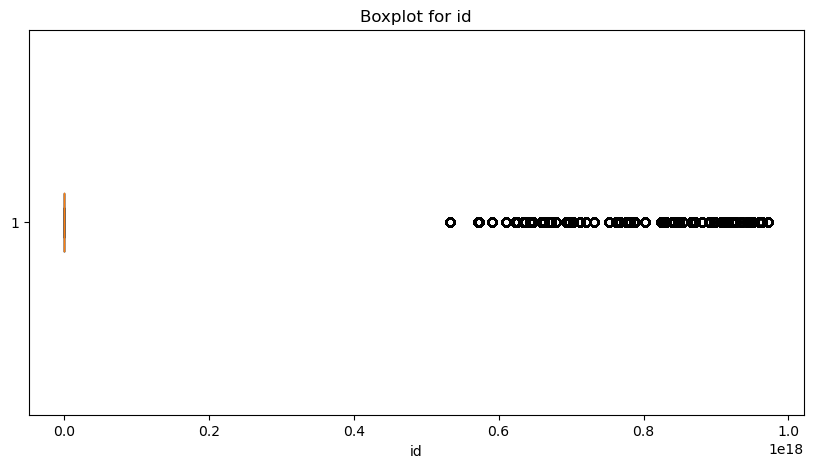

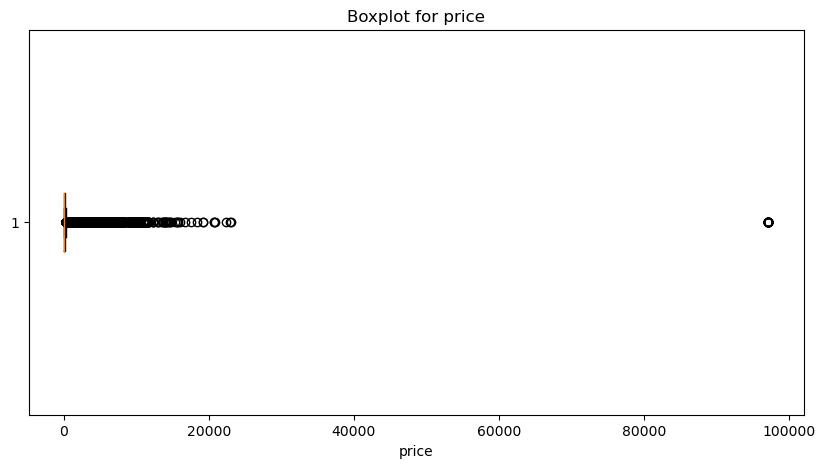

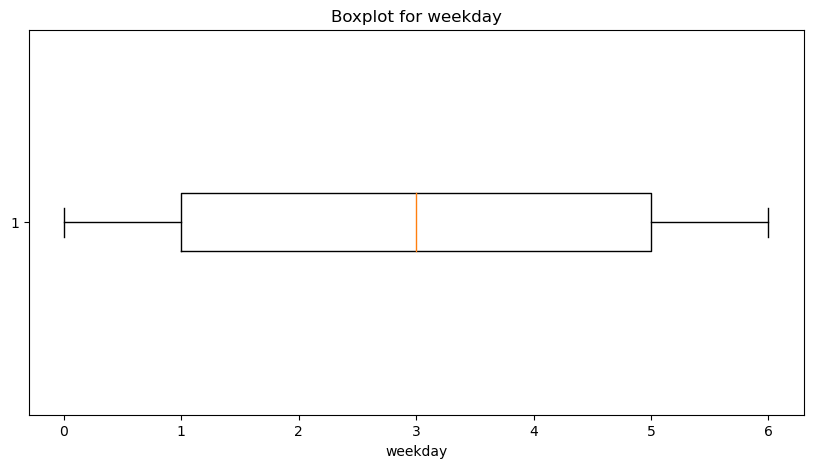

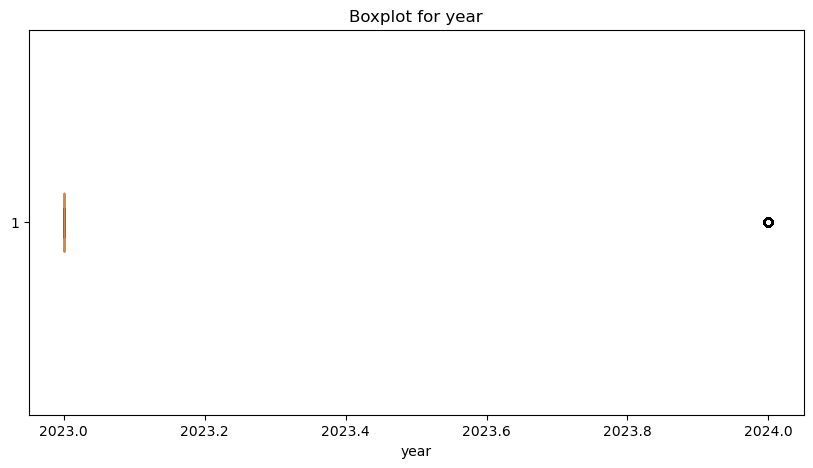

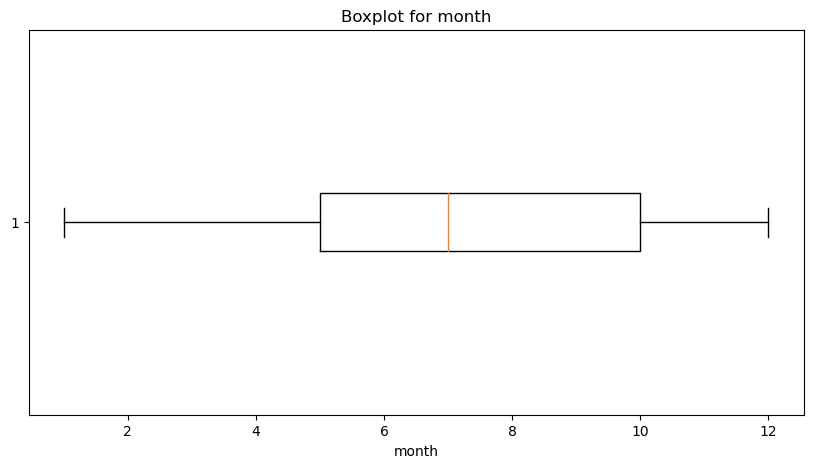

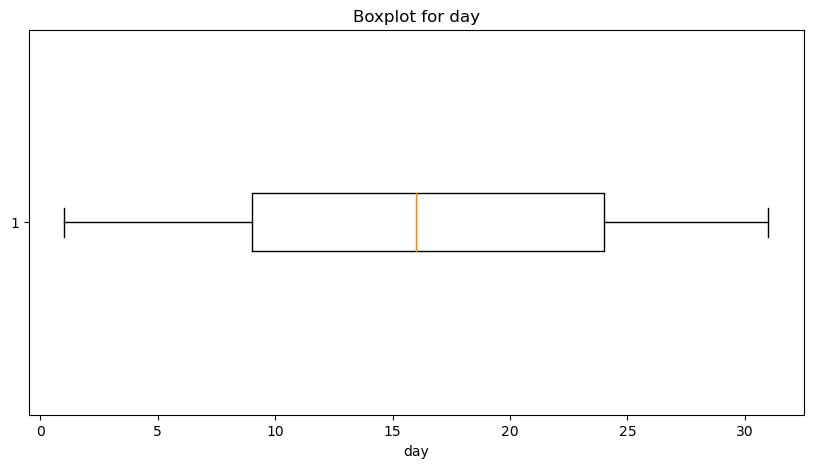

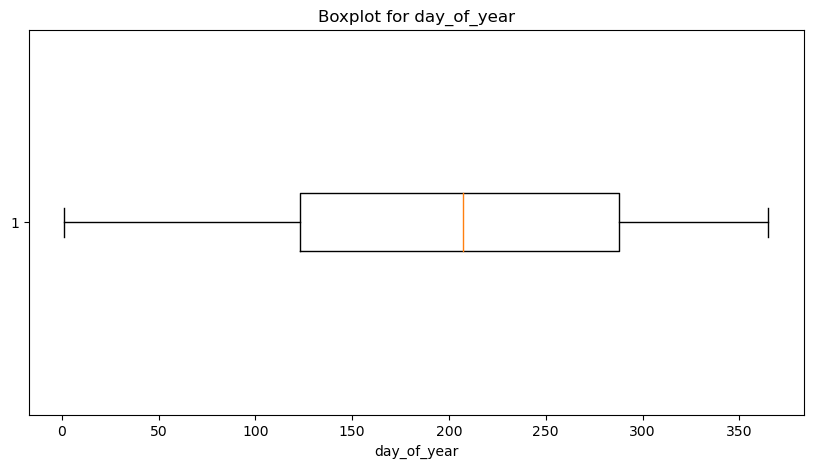

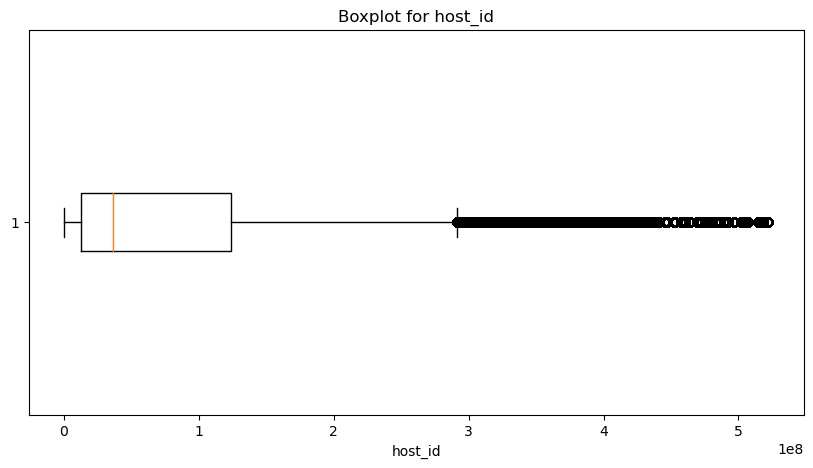

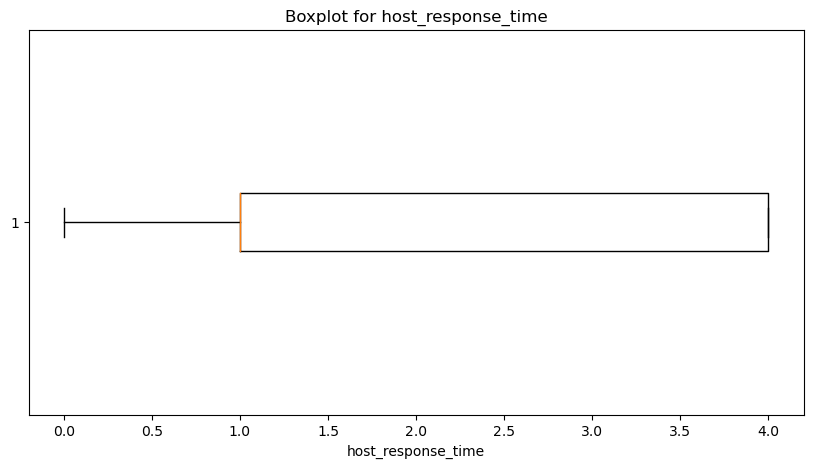

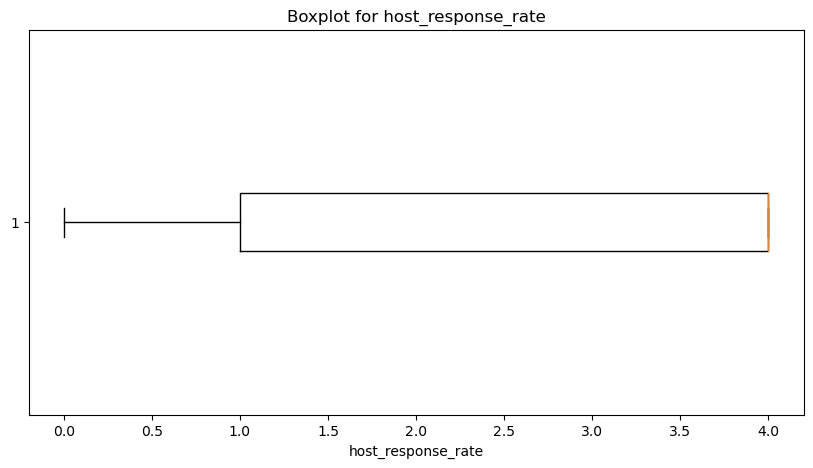

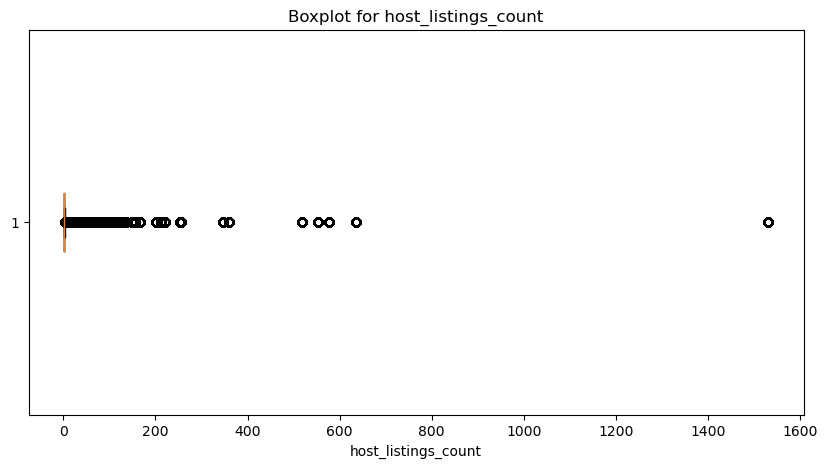

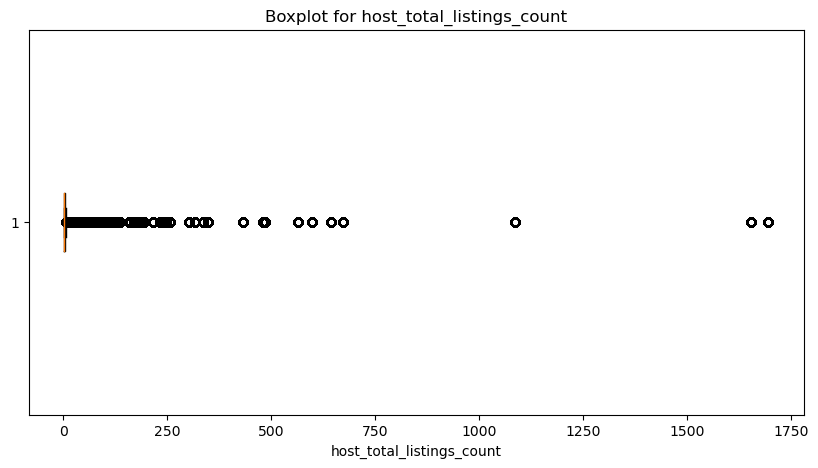

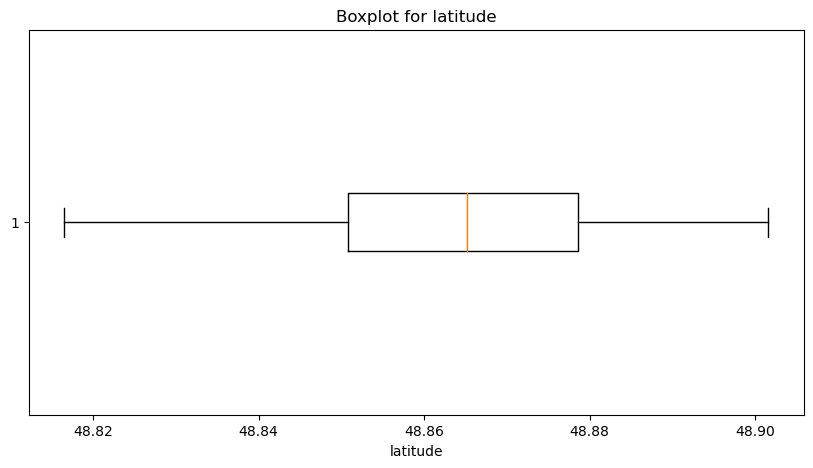

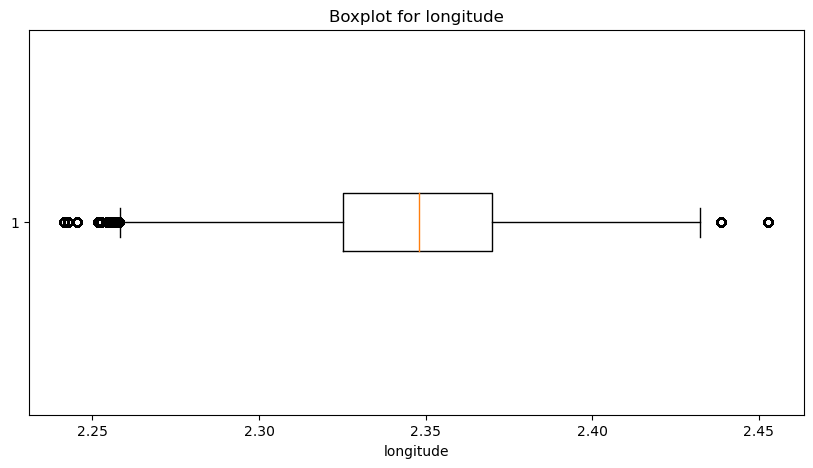

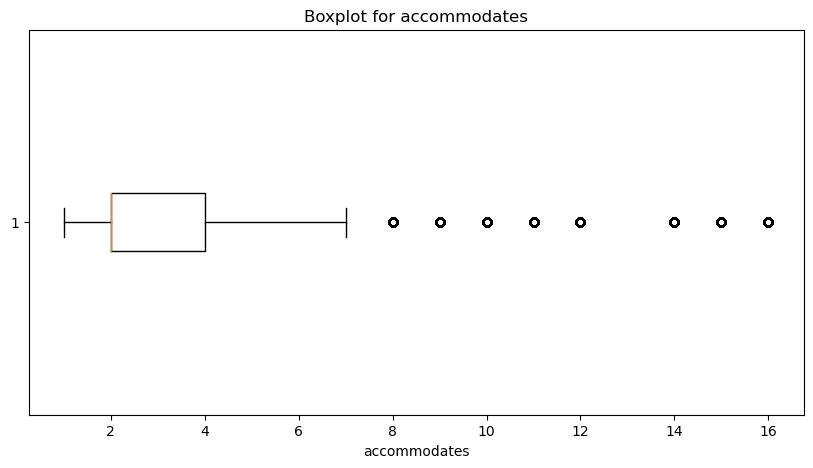

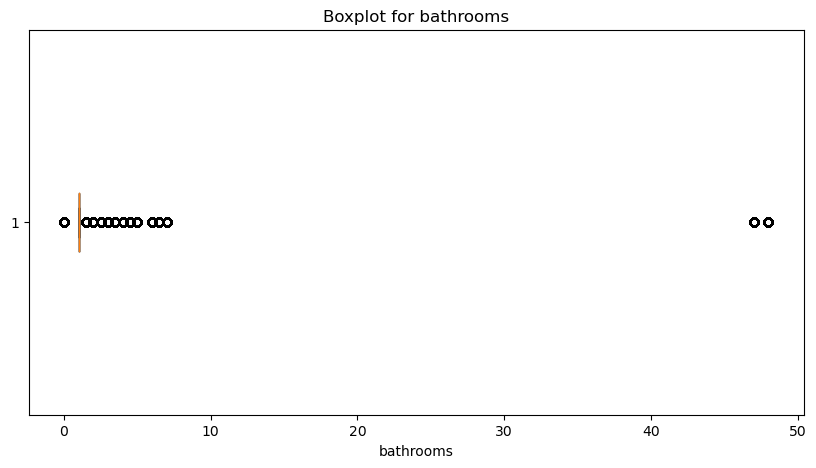

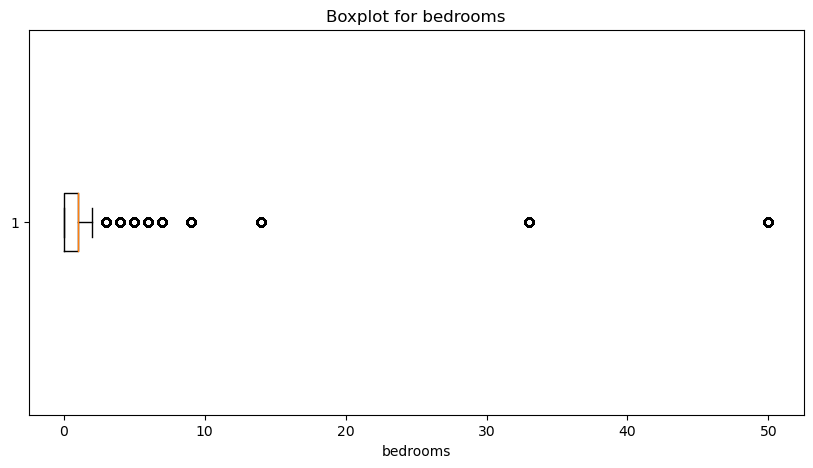

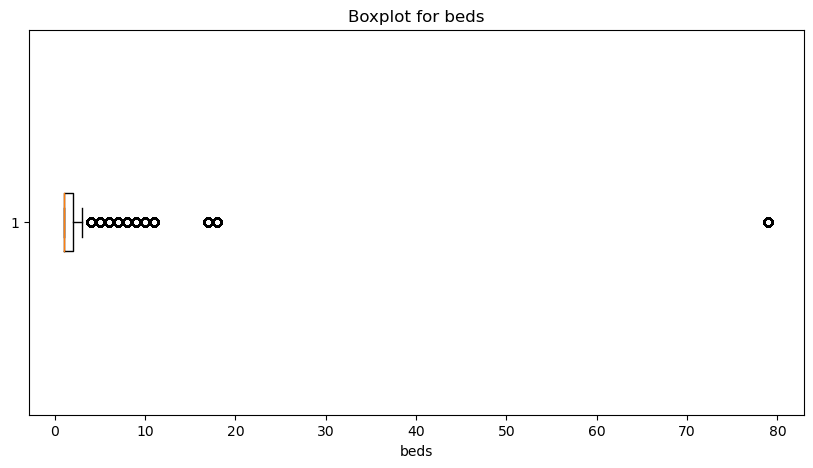

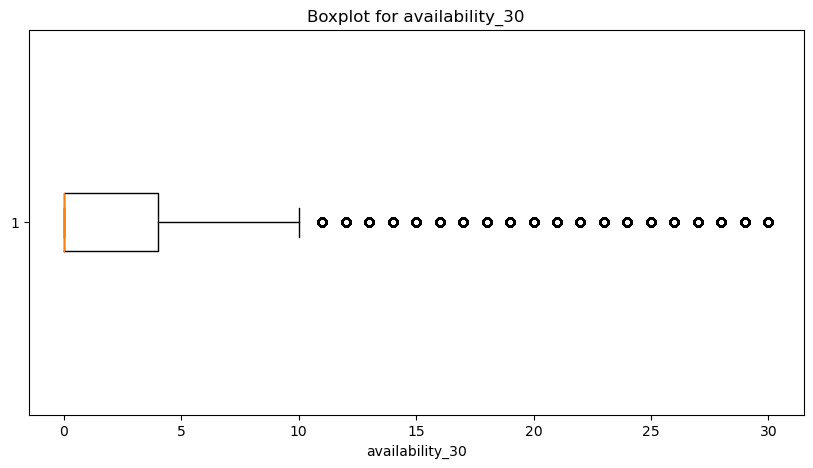

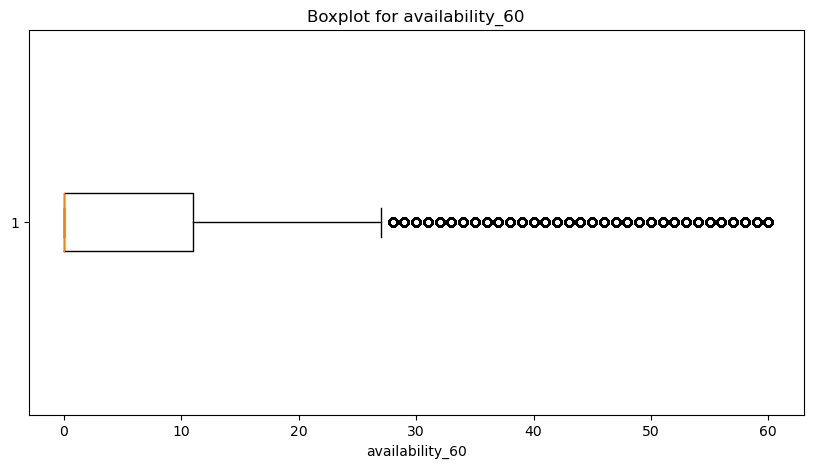

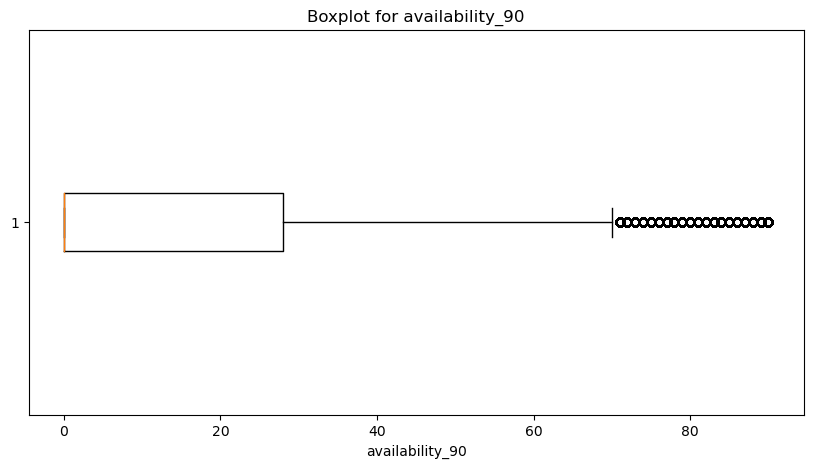

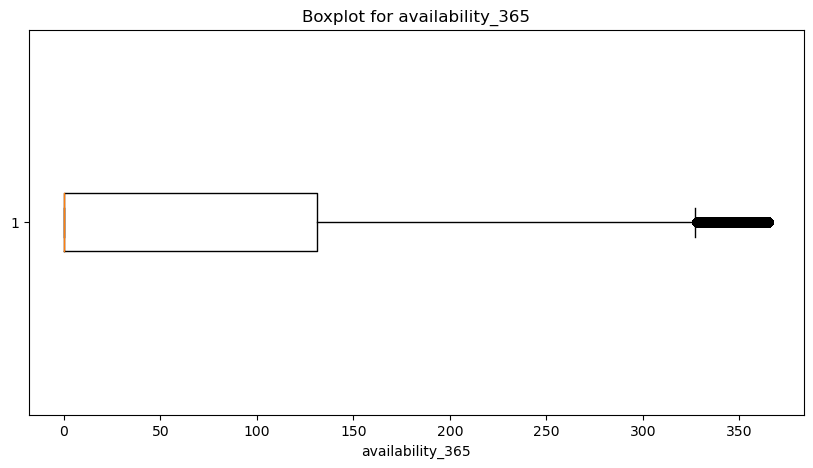

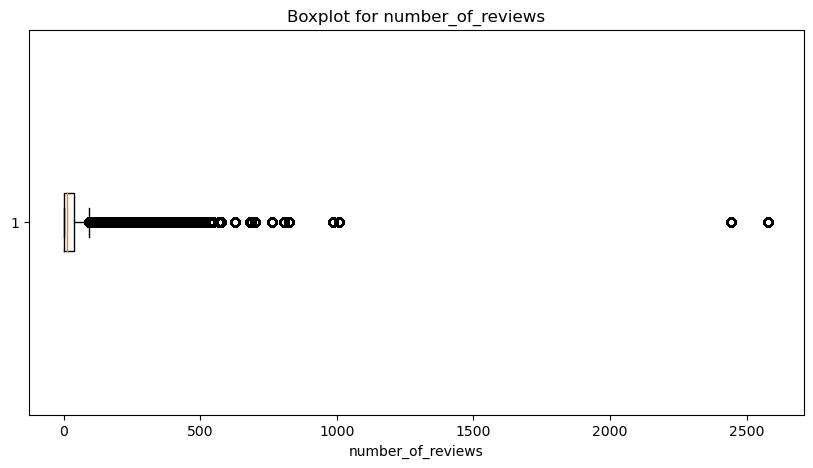

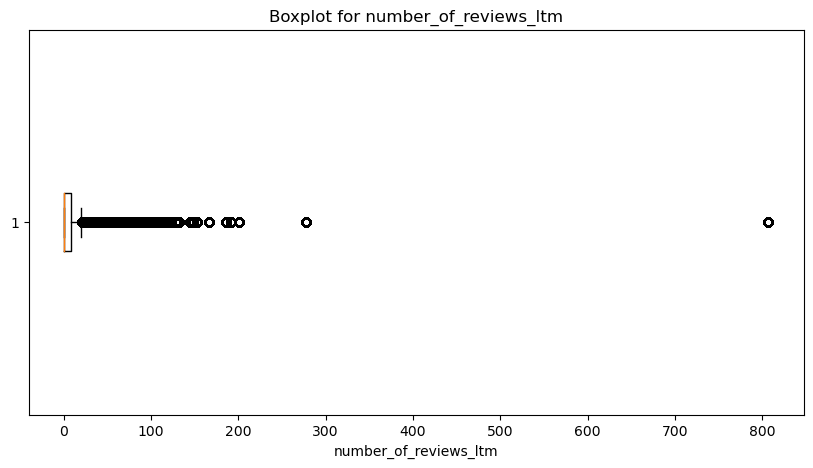

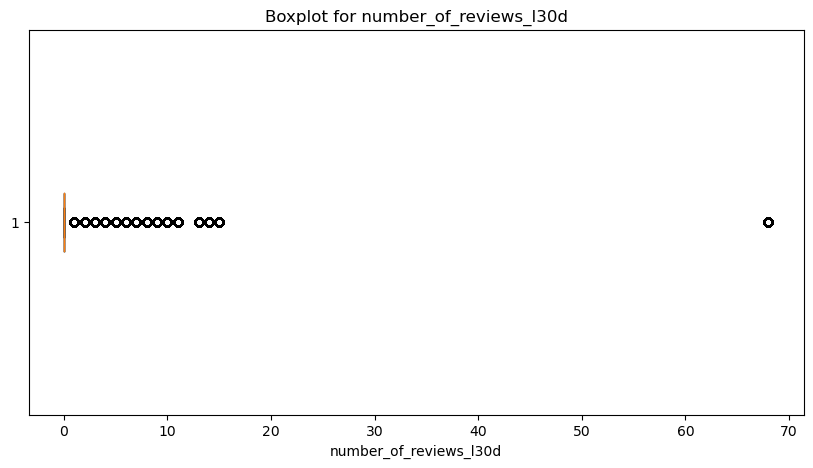

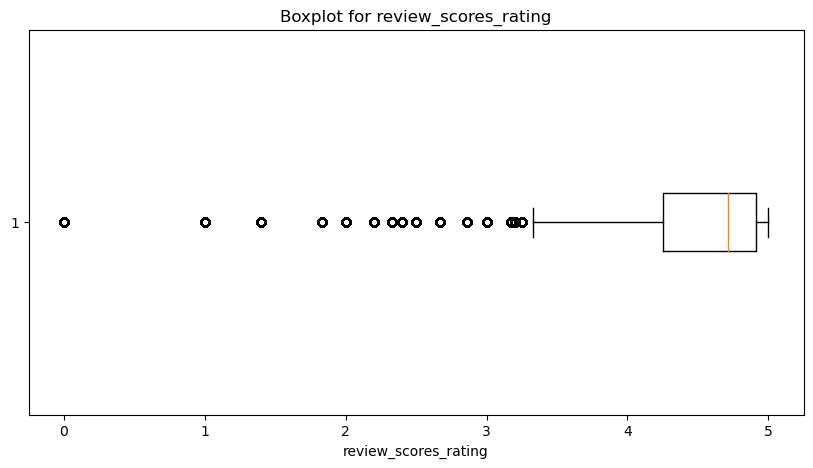

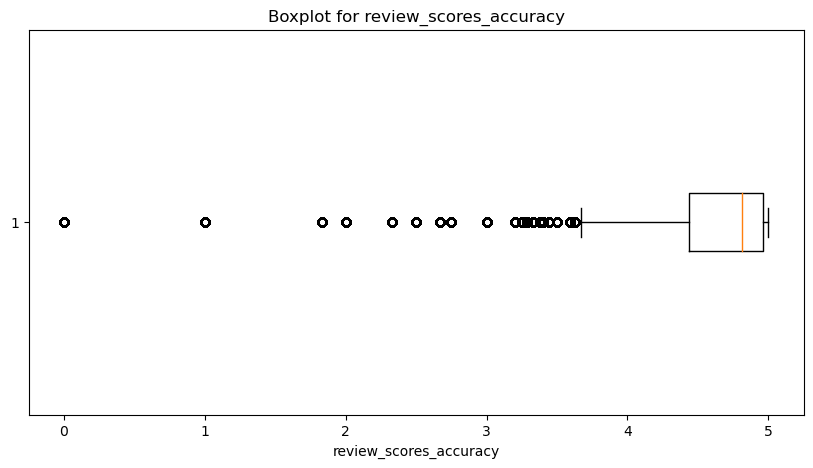

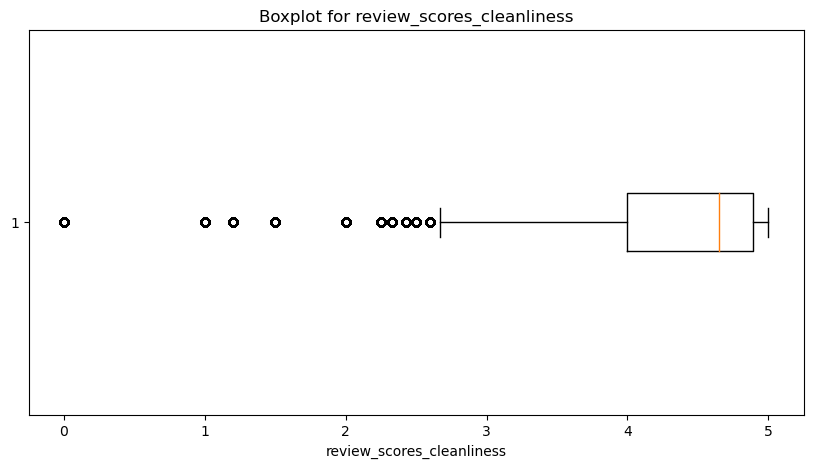

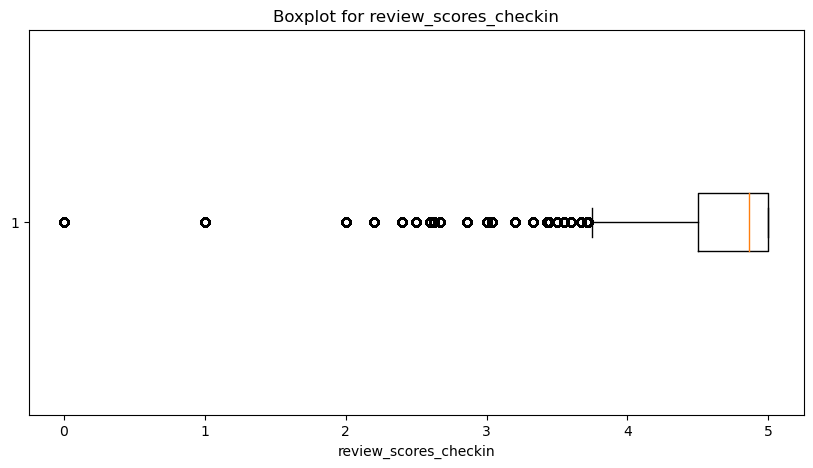

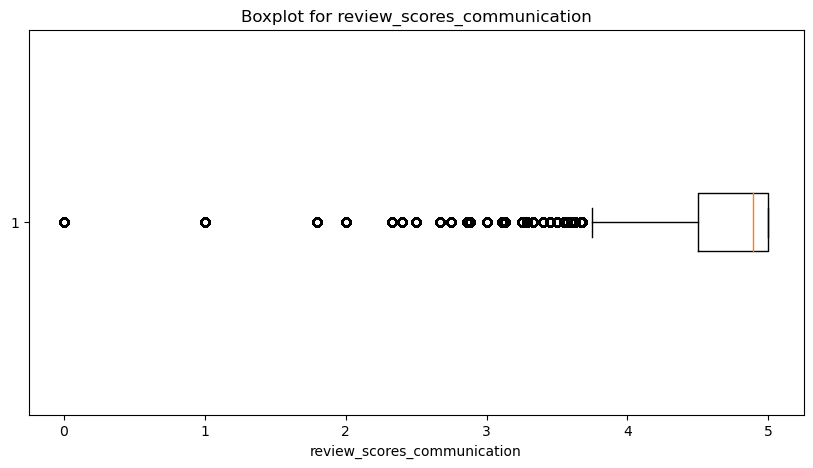

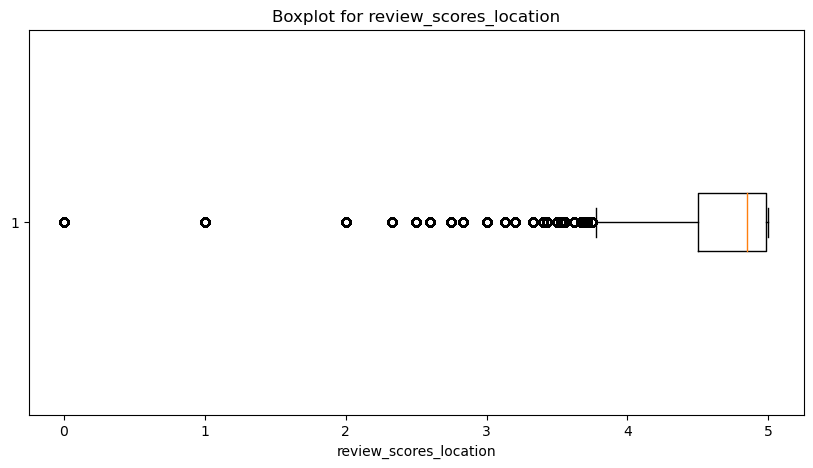

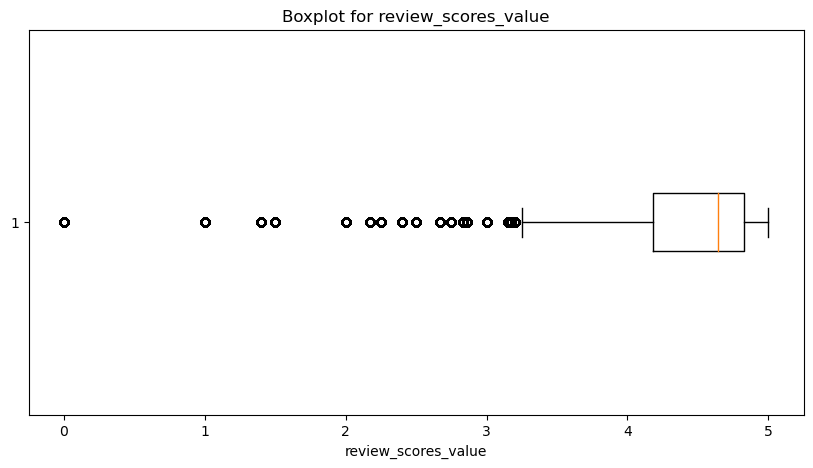

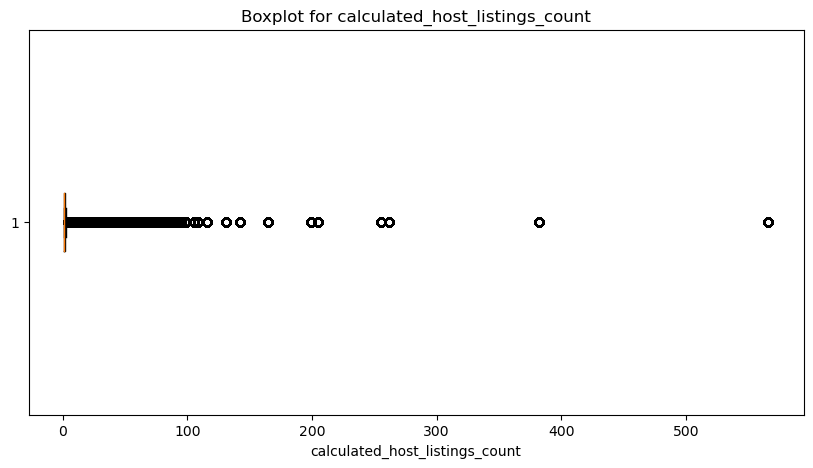

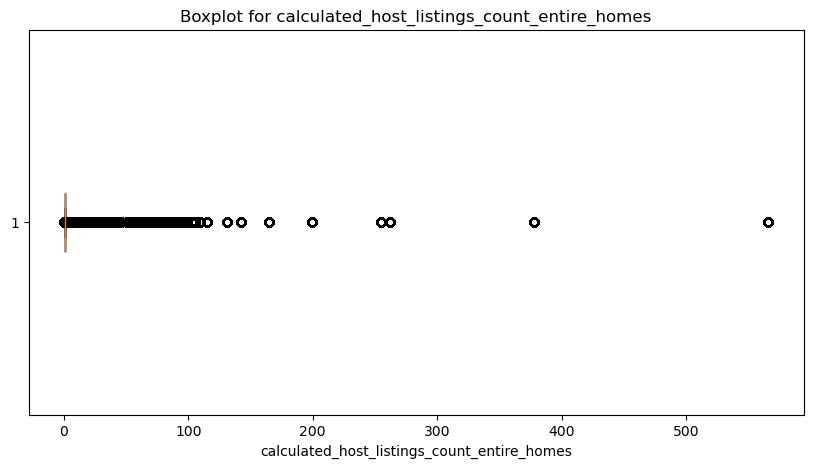

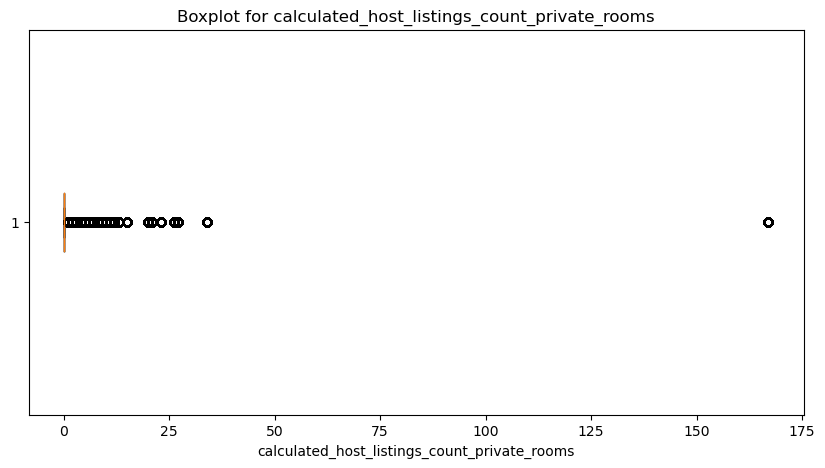

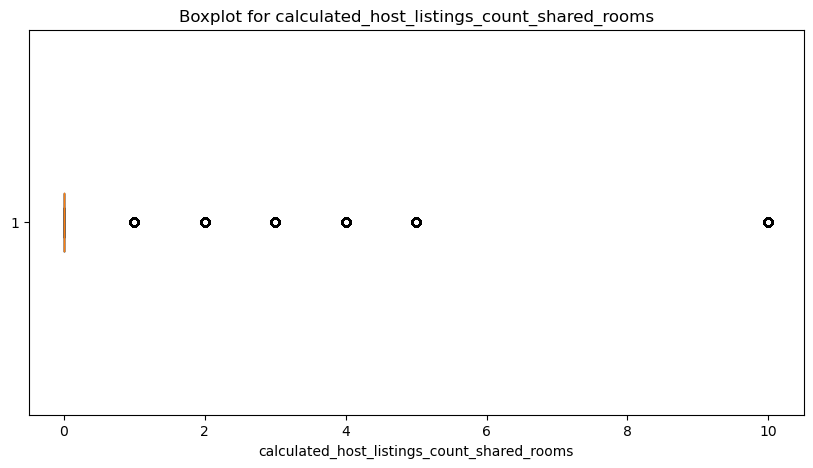

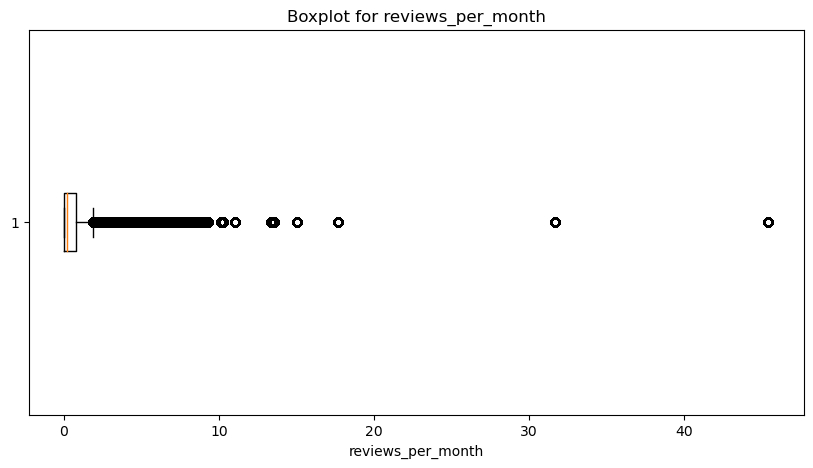

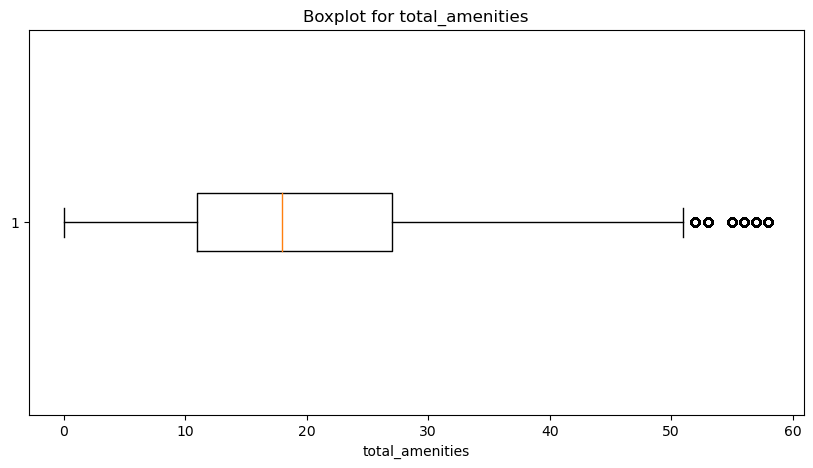

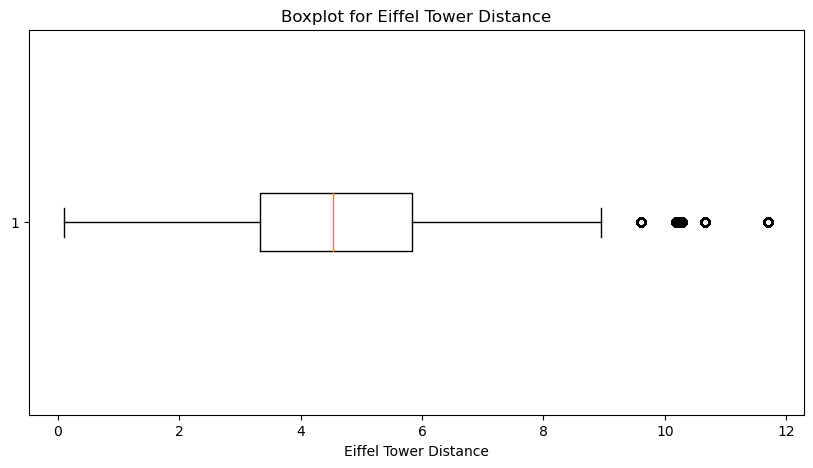

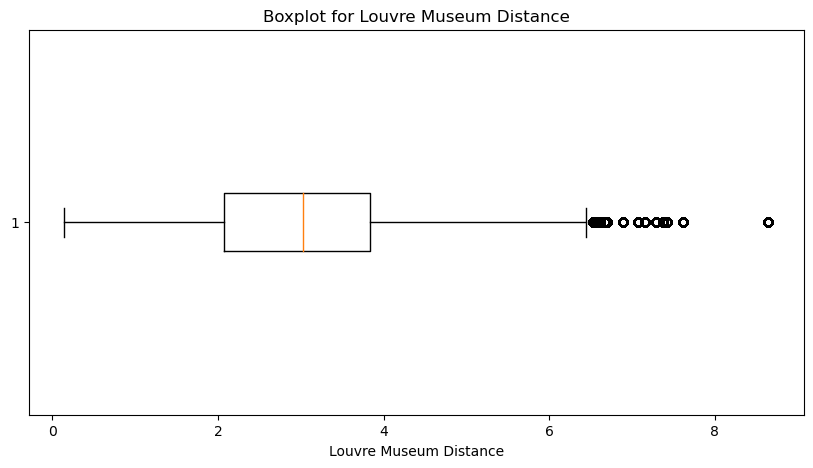

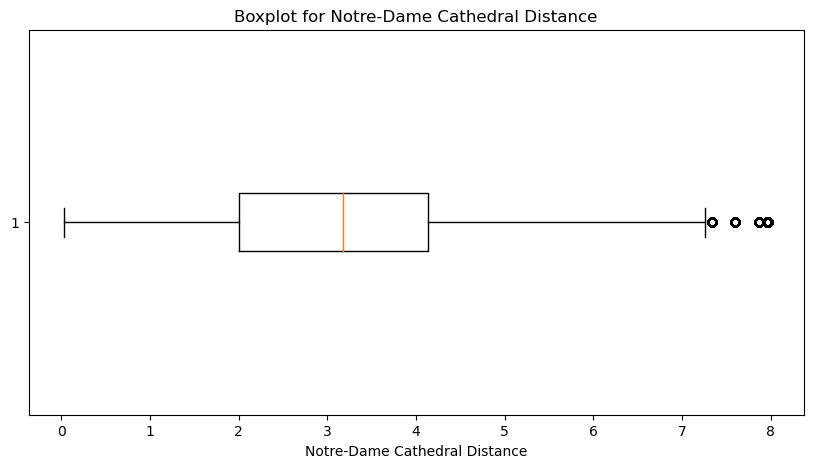

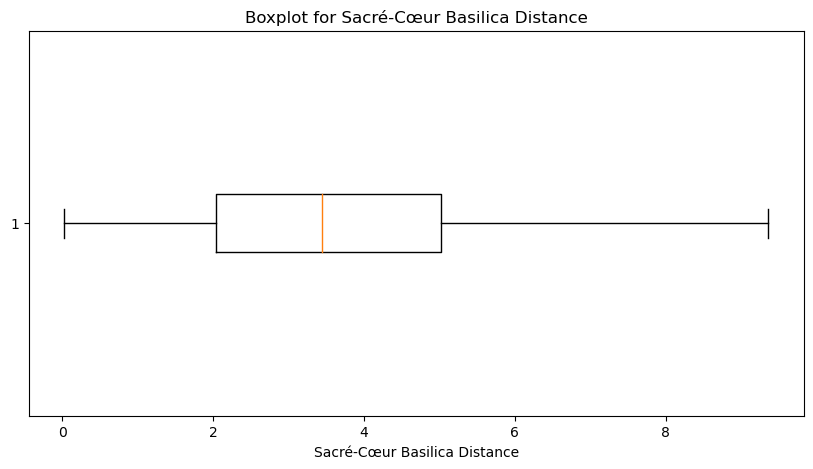

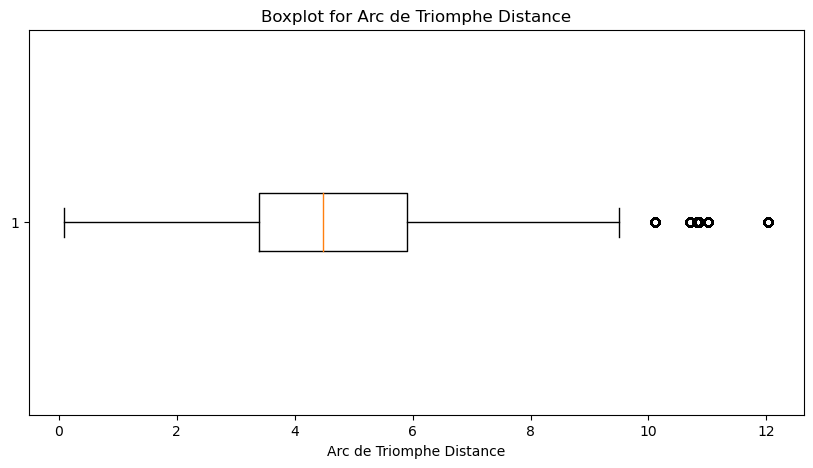

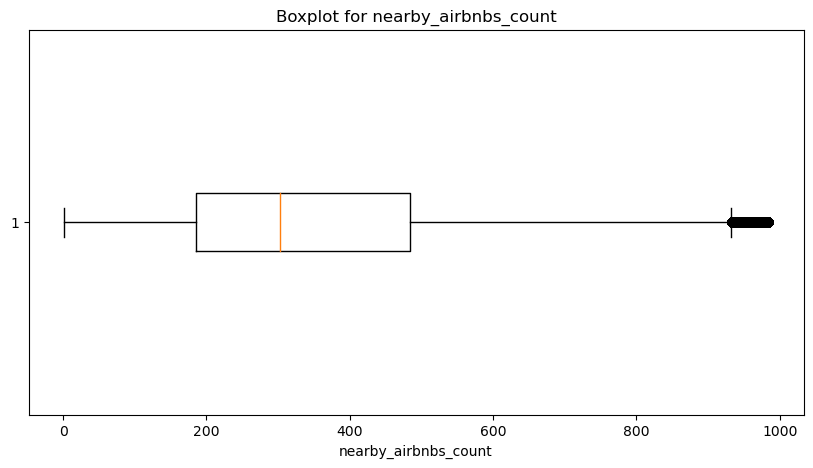

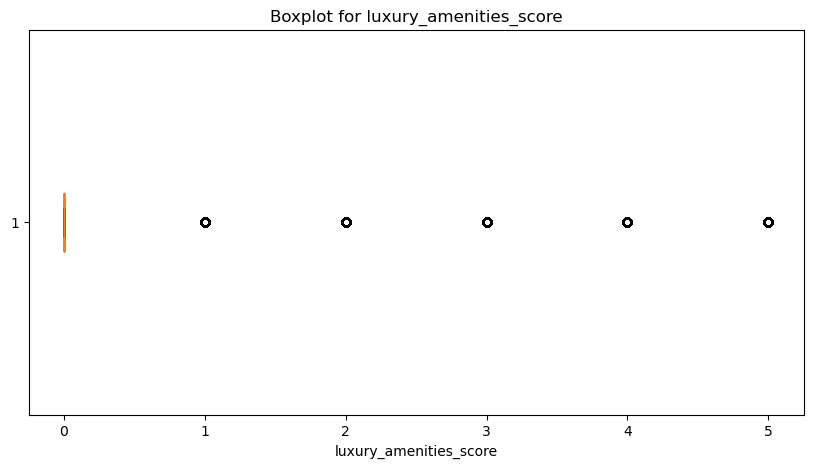

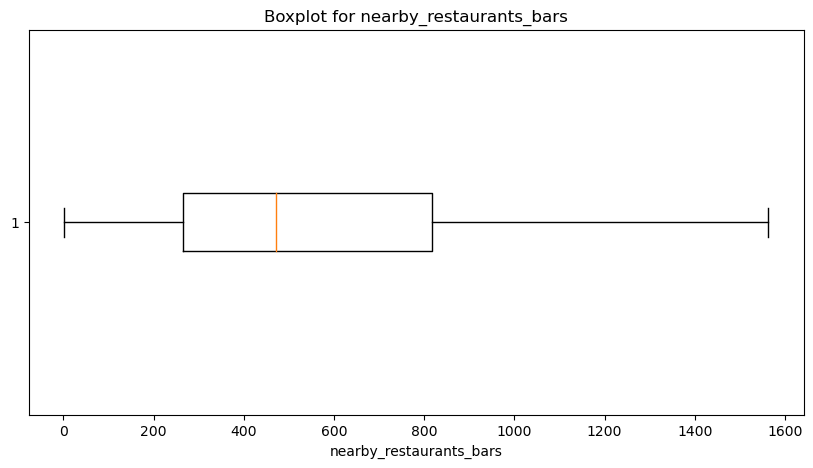

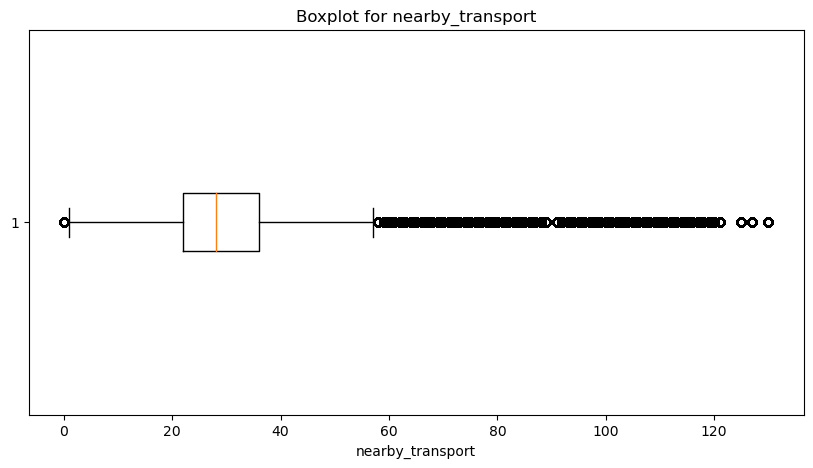

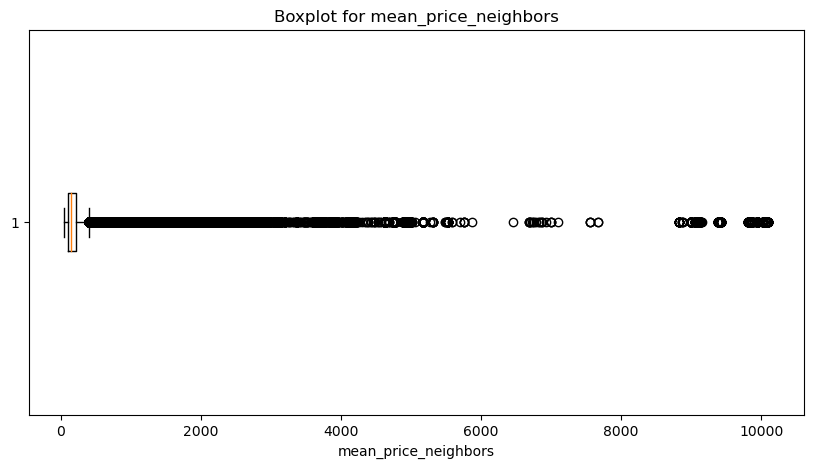

In [135]:
import pandas as pd
import matplotlib.pyplot as plt

# Select only numerical columns
numerical_columns = train_data.select_dtypes(include=['number']).columns

# Plot boxplots for each numerical column
for column in numerical_columns:
    plt.figure(figsize=(10, 5))
    plt.boxplot(train_data[column].dropna(), vert=False)
    plt.title(f'Boxplot for {column}')
    plt.xlabel(column)
    plt.show()

In [136]:
import pandas as pd
import numpy as np

# Ensure the required columns are present in the DataFrame
excluded_columns = ['longitude', 'latitude', 'id', 'host_id']

# Select numerical columns except the excluded ones
numerical_columns = train_data.select_dtypes(include=['number']).columns
numerical_columns = [col for col in numerical_columns if col not in excluded_columns]

# Function to identify outliers using z-score
def identify_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    outliers = df[z_scores > threshold]
    return outliers

# Analyze outliers for each numerical column
for column in numerical_columns:
    outliers = identify_outliers_zscore(train_data, column)
    num_outliers = len(outliers)
    
    # Print outlier statistics
    print(f"Number of outliers in '{column}': {num_outliers}")

Number of outliers in 'price': 16790
Number of outliers in 'weekday': 0
Number of outliers in 'year': 365862
Number of outliers in 'month': 0
Number of outliers in 'day': 0
Number of outliers in 'day_of_year': 0
Number of outliers in 'host_response_time': 0
Number of outliers in 'host_response_rate': 0
Number of outliers in 'host_listings_count': 53164
Number of outliers in 'host_total_listings_count': 55261
Number of outliers in 'accommodates': 64676
Number of outliers in 'bathrooms': 12599
Number of outliers in 'bedrooms': 16604
Number of outliers in 'beds': 38947
Number of outliers in 'availability_30': 84918
Number of outliers in 'availability_60': 0
Number of outliers in 'availability_90': 0
Number of outliers in 'availability_365': 0
Number of outliers in 'number_of_reviews': 62619
Number of outliers in 'number_of_reviews_ltm': 67187
Number of outliers in 'number_of_reviews_l30d': 65199
Number of outliers in 'review_scores_rating': 0
Number of outliers in 'review_scores_accuracy'

In [125]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3669273 entries, 1926225 to 6830888
Columns: 159 entries, id to mean_price_neighbors
dtypes: bool(110), datetime64[ns](1), float64(21), int32(1), int64(26)
memory usage: 1.7 GB


In [126]:
import pandas as pd
import numpy as np

# Columns that need to be corrected for outliers
columns_to_correct = [
    'price', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'total_amenities',
    'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'reviews_per_month', 'nearby_transport'
]

# Make a copy of the train_data
train_data_corrected = train_data.copy()

# Function to identify and remove outliers using z-score
def remove_outliers_zscore(df, columns, threshold=3):
    for column in columns:
        z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
        df = df[z_scores <= threshold]
    return df

# Apply the function to remove outliers
train_data_corrected = remove_outliers_zscore(train_data_corrected, columns_to_correct)

# Print the sizes of the original and corrected datasets to verify
print(f"Original train_data size: {train_data.shape[0]}")
print(f"Corrected train_data size: {train_data_corrected.shape[0]}")

# Optionally, save the corrected dataset to a CSV file
# train_data_corrected.to_csv('train_data_corrected.csv', index=False)

Original train_data size: 3669273
Corrected train_data size: 2776915


In [137]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm

# Check if the required columns are present in the DataFrame
required_columns = ['latitude', 'longitude', 'price', 'date']
missing_columns = [col for col in required_columns if col not in train_data_corrected.columns]

if missing_columns:
    raise KeyError(f"The following required columns are missing from the DataFrame: {missing_columns}")

# Initialize a list to store mean neighbor prices for each row
mean_neighbor_prices = []

# Group by date
grouped = train_data_corrected.groupby('date')

# Iterate over each group (i.e., each date)
for date, group in tqdm(grouped, desc="Processing dates"):
    if len(group) < 2:
        # If there's less than 2 listings for a date, use the original price for that row
        mean_neighbor_prices.extend(group['price'])
        continue
    
    # Prepare data for KDTree
    coordinates = group[['latitude', 'longitude']].values
    prices = group['price'].values
    
    # Build the KDTree for fast lookup of nearest neighbors
    tree = cKDTree(coordinates)
    
    # Define the number of neighbors to consider (5 closest neighbors)
    k = 10
    
    # Query the tree for the k nearest neighbors for each listing
    distances, indices = tree.query(coordinates, k=k+1)  # k+1 because the nearest neighbor includes the point itself
    
    # Calculate mean price of the nearest neighbors, excluding the point itself
    for idx in indices:
        mean_price = prices[idx[1:]].mean()  # Exclude the point itself
        mean_neighbor_prices.append(mean_price)

# Add the mean_neighbor_prices as a new column in the DataFrame
train_data_corrected['mean_price_neighbors'] = np.round(mean_neighbor_prices).astype(int)

# Display the result
print(train_data_corrected["mean_price_neighbors"].describe())

Processing dates: 100%|██████████| 325/325 [00:22<00:00, 14.13it/s]


count    2.776915e+06
mean     1.257745e+02
std      5.205381e+01
min      4.600000e+01
25%      8.900000e+01
50%      1.120000e+02
75%      1.480000e+02
max      6.820000e+02
Name: mean_price_neighbors, dtype: float64


In [139]:
import pandas as pd
import numpy as np

# Columns that need to be corrected for outliers
columns_to_correct = [
    'price', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'total_amenities',
    'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'reviews_per_month', 'nearby_transport'
]

# Make copies of the valid_data and test_data
valid_data_corrected = valid_data.copy()
test_data_corrected = test_data.copy()

# Calculate the maximum values for the specified columns in the train_data_corrected
max_values = train_data_corrected[columns_to_correct].max()

# Function to remove rows with values higher than the max values in the specified columns
def remove_rows_above_max(df, max_values):
    for column in max_values.index:
        df = df[df[column] <= max_values[column]]
    return df

# Apply the function to valid_data and test_data
valid_data_corrected = remove_rows_above_max(valid_data_corrected, max_values)
test_data_corrected = remove_rows_above_max(test_data_corrected, max_values)

# Print the sizes of the original and corrected datasets to verify
print(f"Original valid_data size: {valid_data.shape[0]}")
print(f"Corrected valid_data size: {valid_data_corrected.shape[0]}")
print(f"Original test_data size: {test_data.shape[0]}")
print(f"Corrected test_data size: {test_data_corrected.shape[0]}")

Original valid_data size: 424872
Corrected valid_data size: 321564
Original test_data size: 426532
Corrected test_data size: 323624


In [140]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm

# Check if the required columns are present in the DataFrame
required_columns = ['latitude', 'longitude', 'price', 'date']
missing_columns = [col for col in required_columns if col not in valid_data_corrected.columns]

if missing_columns:
    raise KeyError(f"The following required columns are missing from the DataFrame: {missing_columns}")

# Initialize a list to store mean neighbor prices for each row
mean_neighbor_prices = []

# Group by date
grouped = valid_data_corrected.groupby('date')

# Iterate over each group (i.e., each date)
for date, group in tqdm(grouped, desc="Processing dates"):
    if len(group) < 2:
        # If there's less than 2 listings for a date, use the original price for that row
        mean_neighbor_prices.extend(group['price'])
        continue
    
    # Prepare data for KDTree
    coordinates = group[['latitude', 'longitude']].values
    prices = group['price'].values
    
    # Build the KDTree for fast lookup of nearest neighbors
    tree = cKDTree(coordinates)
    
    # Define the number of neighbors to consider (5 closest neighbors)
    k = 10
    
    # Query the tree for the k nearest neighbors for each listing
    distances, indices = tree.query(coordinates, k=k+1)  # k+1 because the nearest neighbor includes the point itself
    
    # Calculate mean price of the nearest neighbors, excluding the point itself
    for idx in indices:
        mean_price = prices[idx[1:]].mean()  # Exclude the point itself
        mean_neighbor_prices.append(mean_price)

# Add the mean_neighbor_prices as a new column in the DataFrame
valid_data_corrected['mean_price_neighbors'] = np.round(mean_neighbor_prices).astype(int)

# Display the result
print(valid_data_corrected["mean_price_neighbors"].describe())

Processing dates: 100%|██████████| 108/108 [00:02<00:00, 43.31it/s]

count    321564.000000
mean        134.607624
std          57.416613
min          52.000000
25%          95.000000
50%         120.000000
75%         154.000000
max         491.000000
Name: mean_price_neighbors, dtype: float64


In [141]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm

# Check if the required columns are present in the DataFrame
required_columns = ['latitude', 'longitude', 'price', 'date']
missing_columns = [col for col in required_columns if col not in test_data_corrected.columns]

if missing_columns:
    raise KeyError(f"The following required columns are missing from the DataFrame: {missing_columns}")

# Initialize a list to store mean neighbor prices for each row
mean_neighbor_prices = []

# Group by date
grouped = test_data_corrected.groupby('date')

# Iterate over each group (i.e., each date)
for date, group in tqdm(grouped, desc="Processing dates"):
    if len(group) < 2:
        # If there's less than 2 listings for a date, use the original price for that row
        mean_neighbor_prices.extend(group['price'])
        continue
    
    # Prepare data for KDTree
    coordinates = group[['latitude', 'longitude']].values
    prices = group['price'].values
    
    # Build the KDTree for fast lookup of nearest neighbors
    tree = cKDTree(coordinates)
    
    # Define the number of neighbors to consider (5 closest neighbors)
    k = 10
    
    # Query the tree for the k nearest neighbors for each listing
    distances, indices = tree.query(coordinates, k=k+1)  # k+1 because the nearest neighbor includes the point itself
    
    # Calculate mean price of the nearest neighbors, excluding the point itself
    for idx in indices:
        mean_price = prices[idx[1:]].mean()  # Exclude the point itself
        mean_neighbor_prices.append(mean_price)

# Add the mean_neighbor_prices as a new column in the DataFrame
test_data_corrected['mean_price_neighbors'] = np.round(mean_neighbor_prices).astype(int)

# Display the result
print(test_data_corrected["mean_price_neighbors"].describe())

Processing dates: 100%|██████████| 109/109 [00:02<00:00, 44.08it/s]

count    323624.000000
mean        149.373396
std          69.483450
min          44.000000
25%          97.000000
50%         130.000000
75%         185.000000
max         644.000000
Name: mean_price_neighbors, dtype: float64


In [142]:
train_data_corrected.to_csv('train_data_corrected_outliers.csv', index=False)
valid_data_corrected.to_csv('valid_data_corrected_outliers.csv', index=False)
test_data_corrected.to_csv('test_data_corrected_outliers.csv', index=False)

#### Correlation Analysis 

In [ ]:
!pip install dask

Sampling data...
Computing correlation matrix...

Correlations with price:
bedrooms: 0.36
calculated_host_listings_count: 0.33
property_type_Hotel: 0.33
total_amenities: 0.32
availability_365: 0.31
crib: 0.30
accommodates: 0.29
room_type_Hotel room: 0.29
availability_90: 0.27
Fire extinguisher: 0.27
beds: 0.26
mean_price_neighbors: 0.26
host_listings_count: 0.26
host_response_time: 0.26
available: 0.26
availability_60: 0.25
Dishwasher: 0.24
luxury_amenities_score: 0.24
Luggage dropoff allowed: 0.24
Extra pillows and blankets: 0.23
bathrooms: 0.22
availability_30: 0.22
Bed linens: 0.22
Bathtub: 0.21
Self check-in: 0.21
coffee: 0.20
Dedicated workspace: 0.20
Hot water: 0.20
parking: 0.20
tv: 0.20
Hair dryer: 0.19
host_is_superhost: 0.19
Shower gel: 0.19
soap: 0.18
Ethernet connection: 0.18
host_total_listings_count: 0.18
Wine glasses: 0.18
Freezer: 0.18
toys children: 0.18
Hot water kettle: 0.18
number_of_reviews_ltm: 0.18
clothing storage: 0.17
oven: 0.17
Toaster: 0.17
Dining table: 0.1

Creating heatmap:   0%|           [Time: 00:00 < ?, ?it/s]

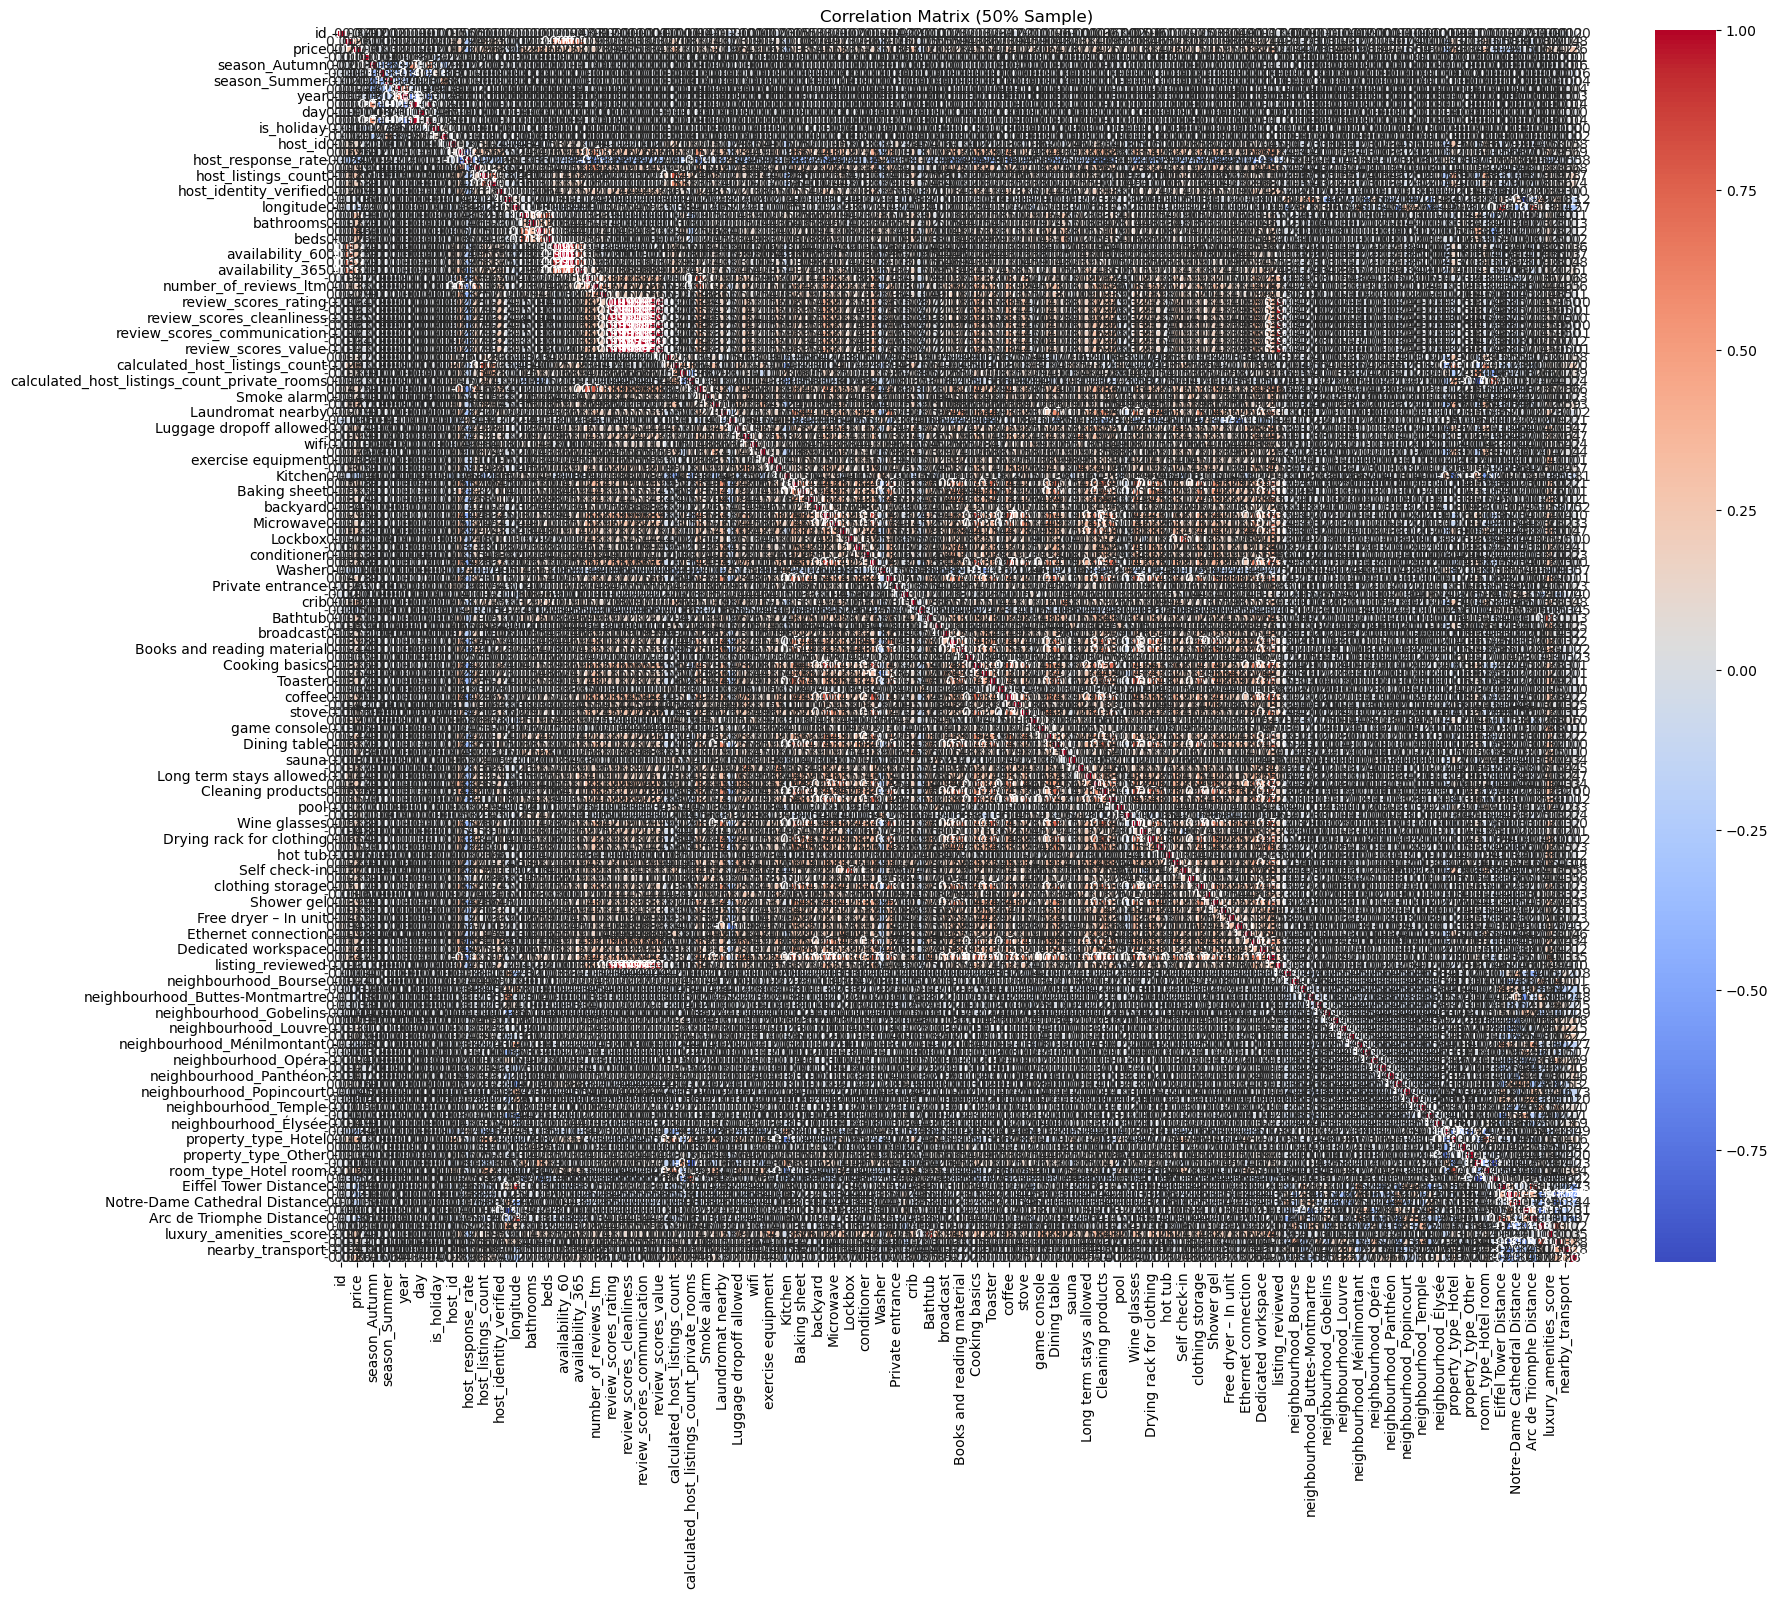

Creating heatmap: 100%|██████████ [Time: 00:32 < 00:00, 32.42s/it]

Time taken for heatmap visualization: 32.42 seconds
Total time taken: 86.60 seconds


In [152]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

# Convert the DataFrame to a Dask DataFrame
dask_df = dd.from_pandas(train_data_corrected, npartitions=10)

# Define the target column
target = 'price'

# Track the start time
start_time = time.time()

# Sample 50% of the data using Dask
print("Sampling data...")
sampled_dask_df = dask_df.sample(frac=0.50, random_state=1).compute()

# Convert the sampled data back to a Pandas DataFrame for correlation computation
sampled_data = pd.DataFrame(sampled_dask_df)

# Filter out non-numeric and boolean columns
numeric_data = sampled_data.select_dtypes(include=[float, int, bool]).copy()

# Temporarily convert boolean columns to integers for correlation computation
boolean_columns = numeric_data.select_dtypes(include=[bool]).columns
numeric_data[boolean_columns] = numeric_data[boolean_columns].astype(int)

# Check for constant columns and remove them
constant_columns = [col for col in numeric_data.columns if numeric_data[col].nunique() <= 1]
if constant_columns:
    print(f"Removing constant columns: {constant_columns}")
    numeric_data.drop(columns=constant_columns, inplace=True)

# Compute the correlation matrix for the numeric data
print("Computing correlation matrix...")
correlation_matrix = numeric_data.corr()

# Calculate correlations with the target column
correlations_with_target = correlation_matrix[target].dropna().sort_values(ascending=False)

# Display the correlations with the target column, sorted
print(f"\nCorrelations with {target}:")
for col, value in correlations_with_target.items():
    if col != target:
        print(f"{col}: {value:.2f}")

# Time taken for sampling and correlation computation
sampling_time = time.time() - start_time
print(f"Time taken for sampling and correlation computation: {sampling_time:.2f} seconds")

# Track time for heatmap visualization with tqdm progress
print("Visualizing heatmap...")
with tqdm(total=1, desc="Creating heatmap", bar_format="{l_bar}{bar} [Time: {elapsed} < {remaining}, {rate_fmt}{postfix}]") as pbar:
    visualization_start_time = time.time()
    
    # Visualize the correlations with a heatmap
    plt.figure(figsize=(20, 16))  # Adjust the size if needed
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix (50% Sample)')
    plt.show()
    
    # Update the progress bar
    pbar.update(1)

# Time taken for heatmap visualization
visualization_time = time.time() - visualization_start_time
print(f"Time taken for heatmap visualization: {visualization_time:.2f} seconds")

# Total time
total_time = time.time() - start_time
print(f"Total time taken: {total_time:.2f} seconds")

In [146]:
train_data_corrected["room_type_Shared room"].describe()

count     2776915
unique          1
top         False
freq      2776915
Name: room_type_Shared room, dtype: object

In [147]:
columns_to_drop =["room_type_Shared room","calculated_host_listings_count_shared_rooms"]
train_data_corrected = train_data_corrected.drop(columns_to_drop, axis=1)
valid_data_corrected = valid_data_corrected.drop(columns_to_drop, axis=1)
test_data_corrected = test_data_corrected.drop(columns_to_drop, axis=1)

In [153]:
import pandas as pd

# Assuming 'correlation_matrix' is already computed
# and 'target' is defined as 'price'

# Extract the correlation values for the target variable
correlation_with_target = correlation_matrix[target]

# Create a DataFrame to hold both absolute and actual values
correlation_df = pd.DataFrame({
    'Correlation': correlation_with_target,
    'Absolute Correlation': correlation_with_target.abs()
})

# Sort by absolute correlation values
sorted_correlation_df = correlation_df.sort_values(by='Absolute Correlation', ascending=False)

# Top 10 features most correlated with the target
top_10_features = sorted_correlation_df.iloc[1:11]  # Exclude the target itself

# Bottom 10 features least correlated with the target
bottom_10_features = sorted_correlation_df.iloc[-10:]

# Display the top 10 and bottom 10 features
print("Top 10 features most correlated with the target variable:")
print(top_10_features[['Correlation', 'Absolute Correlation']])

print("\nBottom 10 features least correlated with the target variable:")
print(bottom_10_features[['Correlation', 'Absolute Correlation']])

Top 10 features most correlated with the target variable:
                                Correlation  Absolute Correlation
bedrooms                           0.364421              0.364421
calculated_host_listings_count     0.331378              0.331378
property_type_Hotel                0.326660              0.326660
total_amenities                    0.315657              0.315657
availability_365                   0.314005              0.314005
crib                               0.301629              0.301629
accommodates                       0.291716              0.291716
room_type_Hotel room               0.287424              0.287424
availability_90                    0.269856              0.269856
host_response_rate                -0.269071              0.269071

Bottom 10 features least correlated with the target variable:
                              Correlation  Absolute Correlation
year                             0.014125              0.014125
listing_reviewed         

In [155]:
import dask.dataframe as dd
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time

# Convert the DataFrame to a Dask DataFrame
dask_df = dd.from_pandas(train_data_corrected, npartitions=10)

# Track the start time
start_time = time.time()

# Sample 50% of the data using Dask
print("Sampling data...")
sampled_dask_df = dask_df.sample(frac=0.50, random_state=1).compute()

# Convert the sampled data back to a Pandas DataFrame
sampled_data = pd.DataFrame(sampled_dask_df)

# Filter out non-numeric and boolean columns
numeric_data = sampled_data.select_dtypes(include=[float, int, bool]).copy()

# Temporarily convert boolean columns to integers for VIF calculation
boolean_columns = numeric_data.select_dtypes(include=[bool]).columns
numeric_data[boolean_columns] = numeric_data[boolean_columns].astype(int)

# Check for constant columns and remove them
constant_columns = [col for col in numeric_data.columns if numeric_data[col].nunique() <= 1]
if constant_columns:
    print(f"Removing constant columns: {constant_columns}")
    numeric_data.drop(columns=constant_columns, inplace=True)

# Function to calculate VIF for each feature
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Calculate VIF values
print("Calculating VIF values...")
vif_df = calculate_vif(numeric_data)

# Display the VIF values
print("\nVIF values:")
print(vif_df.sort_values(by="VIF", ascending=False))

# Time taken for sampling and VIF calculation
total_time = time.time() - start_time
print(f"Total time taken: {total_time:.2f} seconds")

Sampling data...
Calculating VIF values...

VIF values:
                     feature           VIF
9                      month  1.309265e+02
147   Louvre Museum Distance  3.491692e+00
153  nearby_restaurants_bars  3.204700e+00
151     nearby_airbnbs_count  2.930834e+00
29           availability_90  2.704809e+00
..                       ...           ...
13         is_school_holiday  1.000656e+00
12                is_holiday  1.000508e+00
11               day_of_year  1.000398e+00
21                  latitude  1.044202e-01
8                       year  3.574865e-07

[156 rows x 2 columns]
Total time taken: 3742.67 seconds


In [156]:
import pandas as pd

# Assuming vif_df is your DataFrame containing the VIF values

# Save the VIF values to a CSV file
vif_df.to_csv('vif_values.csv', index=False)

print("VIF values saved to 'vif_values.csv'")

VIF values saved to 'vif_values.csv'


In [157]:
# Assuming correlation_matrix and high_vif_df have been already calculated

# Filter VIF values above 5
high_vif_df = vif_df[vif_df["VIF"] > 5]

# Display the high VIF values
print("\nVIF values above 5:")
print(high_vif_df.sort_values(by="VIF", ascending=False))

# Find all pairs of features with a correlation higher than 0.8
high_corr_pairs = []
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Display the pairs of features with high correlations
print("\nPairs of features with absolute correlation higher than 0.8:")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: correlation = {pair[2]:.2f}")



VIF values above 5:
  feature         VIF
9   month  130.926456

Pairs of features with absolute correlation higher than 0.8:
month and day_of_year: correlation = 1.00
latitude and Sacré-Cœur Basilica Distance: correlation = -0.88
longitude and Eiffel Tower Distance: correlation = 0.93
longitude and Arc de Triomphe Distance: correlation = 0.84
availability_30 and availability_60: correlation = 0.97
availability_30 and availability_90: correlation = 0.92
availability_60 and availability_90: correlation = 0.97
review_scores_rating and review_scores_accuracy: correlation = 0.99
review_scores_rating and review_scores_cleanliness: correlation = 0.99
review_scores_rating and review_scores_checkin: correlation = 0.99
review_scores_rating and review_scores_communication: correlation = 0.99
review_scores_rating and review_scores_location: correlation = 0.98
review_scores_rating and review_scores_value: correlation = 0.99
review_scores_rating and listing_reviewed: correlation = 0.93
review_scor

In [159]:
#decided columns to drop based on the correlation and multivariate analysis
columns_to_drop =["review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication"
                 ,"review_scores_location","review_scores_value","day_of_year","availability_60","availability_30"
                 , "room_type_Entire home/apt"]
train_data_corrected = train_data_corrected.drop(columns_to_drop, axis=1)
valid_data_corrected = valid_data_corrected.drop(columns_to_drop, axis=1)
test_data_corrected = test_data_corrected.drop(columns_to_drop, axis=1)

In [160]:
import pandas as pd

# Assuming train_data_corrected, valid_data_corrected, and test_data_corrected are your DataFrames

# Define the kitchen-related features to combine
kitchen_features = ['Dishes and silverware', 'refrigerator', 'Cooking basics']

# Create a new feature 'kitchen_amenities' as the sum of the kitchen-related features for train_data_corrected
train_data_corrected['kitchen_amenities'] = train_data_corrected[kitchen_features].sum(axis=1)
# Drop the original kitchen-related features for train_data_corrected
train_data_corrected = train_data_corrected.drop(columns=kitchen_features)

# Repeat the same for valid_data_corrected
valid_data_corrected['kitchen_amenities'] = valid_data_corrected[kitchen_features].sum(axis=1)
valid_data_corrected = valid_data_corrected.drop(columns=kitchen_features)

# Repeat the same for test_data_corrected
test_data_corrected['kitchen_amenities'] = test_data_corrected[kitchen_features].sum(axis=1)
test_data_corrected = test_data_corrected.drop(columns=kitchen_features)

# Display the first few rows and describe of the modified DataFrames to verify the changes
print("Train Data:")
print(train_data_corrected["kitchen_amenities"].describe())

print("\nValid Data:")
print(valid_data_corrected["kitchen_amenities"].describe())

print("\nTest Data:")
print(test_data_corrected["kitchen_amenities"].describe())

# Optionally, save the modified DataFrames to CSV files
# train_data_corrected.to_csv('train_data_corrected_with_kitchen_amenities.csv', index=False)
# valid_data_corrected.to_csv('valid_data_corrected_with_kitchen_amenities.csv', index=False)
# test_data_corrected.to_csv('test_data_corrected_with_kitchen_amenities.csv', index=False)

Train Data:
               id       date  available  price  weekday  season_Autumn  \
6772313  36215265 2023-03-13      False  100.0        0          False   
9110677  50852255 2023-03-13      False   65.0        0          False   
5457094  27008725 2023-03-13      False  180.0        0          False   
7701765  41366072 2023-03-13      False  120.0        0          False   
9506880  52869209 2023-03-13      False  259.0        0          False   

         season_Spring  season_Summer  season_Winter  year  ...  \
6772313           True          False          False  2023  ...   
9110677           True          False          False  2023  ...   
5457094           True          False          False  2023  ...   
7701765           True          False          False  2023  ...   
9506880           True          False          False  2023  ...   

         Louvre Museum Distance  Notre-Dame Cathedral Distance  \
6772313                4.601323                       4.975816   
9110677 

In [ ]:
train_data_corrected.to_csv('train_data_corrected_with_kitchen_amenities.csv', index=False)
valid_data_corrected.to_csv('valid_data_corrected_with_kitchen_amenities.csv', index=False)
test_data_corrected.to_csv('test_data_corrected_with_kitchen_amenities.csv', index=False)

#### Missing value check

In [161]:
import pandas as pd

# Assuming train_data_corrected, valid_data_corrected, and test_data_corrected are your DataFrames

# Function to check and print rows with missing values
def check_missing_values(df, df_name):
    rows_with_missing_values = df[df.isnull().any(axis=1)]
    
    print(f"Rows with missing values in {df_name}:")
    print(rows_with_missing_values)
    
    # Display the total number of rows with missing values
    print(f"Total number of rows with missing values in {df_name}: {rows_with_missing_values.shape[0]}")
    
    # Optionally, save these rows to a CSV file
    # rows_with_missing_values.to_csv(f'rows_with_missing_values_in_{df_name}.csv', index=False)

# Check for missing values in train_data_corrected
check_missing_values(train_data_corrected, "train_data_corrected")

# Check for missing values in valid_data_corrected
check_missing_values(valid_data_corrected, "valid_data_corrected")

# Check for missing values in test_data_corrected
check_missing_values(test_data_corrected, "test_data_corrected")

Rows with missing values in train_data_corrected:
Empty DataFrame
Columns: [id, date, available, price, weekday, season_Autumn, season_Spring, season_Summer, season_Winter, year, month, day, is_holiday, is_school_holiday, host_id, host_response_time, host_response_rate, host_is_superhost, host_listings_count, host_total_listings_count, host_identity_verified, latitude, longitude, accommodates, bathrooms, bedrooms, beds, availability_90, availability_365, number_of_reviews, number_of_reviews_ltm, number_of_reviews_l30d, review_scores_rating, instant_bookable, calculated_host_listings_count, calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, reviews_per_month, Smoke alarm, Fire extinguisher, Laundromat nearby, Heating, Luggage dropoff allowed, Hair dryer, wifi, First aid kit, exercise equipment, Hangers, Kitchen, Hot water kettle, Baking sheet, Room-darkening shades, backyard, Microwave, Extra pillows and blankets, Lockbox, sound system, conditione

### Saving the final datasets

In [162]:
train_data_corrected.info()
valid_data_corrected.info()
test_data_corrected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2776915 entries, 6772313 to 6830888
Columns: 145 entries, id to kitchen_amenities
dtypes: bool(105), datetime64[ns](1), float64(15), int32(1), int64(23)
memory usage: 1.1 GB
<class 'pandas.core.frame.DataFrame'>
Index: 321564 entries, 9920907 to 6085457
Columns: 145 entries, id to kitchen_amenities
dtypes: bool(105), datetime64[ns](1), float64(15), int32(1), int64(23)
memory usage: 131.6 MB
<class 'pandas.core.frame.DataFrame'>
Index: 323624 entries, 9737797 to 2765348
Columns: 145 entries, id to kitchen_amenities
dtypes: bool(105), datetime64[ns](1), float64(15), int32(1), int64(23)
memory usage: 132.4 MB


In [163]:
train_data_corrected.to_csv('FINAL_TRAIN_DATA_PARIS.csv', index=False)
valid_data_corrected.to_csv('FINAL_VALID_DATA_PARIS.csv', index=False)
test_data_corrected.to_csv('FINAL_TEST_DATA_PARIS.csv', index=False)